# Openclassrooms PJ5 : Online Retail dataset :  modelisation notebook 

In [1]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy


DATA_PATH = os.path.join("datasets", "onlineretail")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "OnlineRetail_transformed.csv")


ALL_FEATURES = []

#MODEL_FEATURES=['InvoiceNo', 'InvoiceDate', 'CustomerID', 'TotalPrice', 'DescriptionNormalized', 'InvoiceMonth', 'StockCode']
MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = True # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
'''
#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ5.pickle'


# Load data

In [2]:
df = load_data(DATA_PATH_FILE_INPUT)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399912 entries, 0 to 399911
Data columns (total 11 columns):
InvoiceNo                399912 non-null object
StockCode                399912 non-null object
Description              399912 non-null object
Quantity                 399912 non-null int64
InvoiceDate              399912 non-null object
UnitPrice                399912 non-null float64
CustomerID               399912 non-null object
Country                  399912 non-null object
TotalPrice               399912 non-null float64
DescriptionNormalized    399912 non-null object
InvoiceMonth             399912 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 33.6+ MB


In [4]:
df, df_train, df_test = custom_train_test_split_sample(df, 'TotalPrice')

In [5]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359920 entries, 0 to 359919
Data columns (total 12 columns):
index                    359920 non-null int64
InvoiceNo                359920 non-null object
StockCode                359920 non-null object
Description              359920 non-null object
Quantity                 359920 non-null int64
InvoiceDate              359920 non-null object
UnitPrice                359920 non-null float64
CustomerID               359920 non-null object
Country                  359920 non-null object
TotalPrice               359920 non-null float64
DescriptionNormalized    359920 non-null object
InvoiceMonth             359920 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 33.0+ MB


In [7]:
df_train_ori = df_train.copy(deep=True)
df_test_ori = df_test.copy(deep=True)

# Top value products (must be saved with the model, and passed to it)

In [8]:
df_nocancel = df_train[df_train['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [9]:
TOP_VALUE_PRODUCT_THRESHOLD = 20
top_value_products = df_gbproduct.sort_values(ascending=False).head(TOP_VALUE_PRODUCT_THRESHOLD).index  # Get top value products

In [10]:
top_value_products

Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode')

# Preparation pipeline : model with bow features + TotalPricePerMonth + BoughtTopValueProduct + HasEverCancelled

In [11]:
importlib.reload(sys.modules['functions'])
from functions import *

In [12]:
df_train = df_train_ori
df_test = df_test_ori


In [13]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [14]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
1
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',


In [15]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Trace 7 before end
Transform log scaler scaler multiple
Transform Min max scaler multiple
Transform Dimensionality Reductor
Remaining columns: ['BoughtTopValueProduct', 'HasEverCancelled', 'TotalPricePerMonth']
Transform Min max scaler multiple


In [16]:
df_train

BoughtTopValueProduct  HasEverCancelled  TotalPricePerMonth         0  \
0                       1.0               1.0            0.877446  0.012337   
1                       1.0               0.0            0.572415  0.356103   
2                       0.0               0.0            0.474029  0.103371   
3                       1.0               0.0            0.707529  0.330665   
4                       0.0               0.0            0.330609  0.073958   
...                     ...               ...                 ...       ...   
4327                    0.0               0.0            0.286691  0.065726   
4328                    0.0               0.0            0.265155  0.043881   
4329                    1.0               1.0            0.370964  0.104478   
4330                    1.0               0.0            0.505393  0.555281   
4331                    0.0               0.0            0.547572  0.231274   

             1         2         3         4         5         6         7  \
0     0.471255  0.453895  0.473793  0.422515  0.477429  0.511299  0.621572   
1     0.422611  0.371563  0.401206  0.423753  0.459668  0.244695  0.315718   
2     0.307434  0.409747  0.364878  0.219234  0.380141  0.622568  0.405009   
3     0.428293  0.241569  0.239619  0.325675  0.390270  0.379993  0.644576   
4     0.425343  0.446213  0.538686  0.277486  0.450344  0.462819  0.479767   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.437382  0.430594  0.463784  0.332083  0.577169  0.449719  0.555757   
4328  0.360628  0.483579  0.481299  0.388442  0.438993  0.351419  0.536795   
4329  0.484576  0.220636  0.328119  0.405983  0.524318  0.437660  0.466580   
4330  0.163908  0.491656  0.360686  0.404089  0.404025  0.757682  0.457156   
4331  0.528386  0.659911  0.299427  0.257503  0.494932  0.598595  0.352469   

             8         9        10        11        12        13        14  \
0     0.503608  0.457640  0.488112  0.409851  0.507055  0.489921  0.535112   
1     0.324960  0.332577  0.361417  0.446315  0.447542  0.669783  0.790501   
2     0.446482  0.327183  0.559740  0.570360  0.614771  0.511387  0.560368   
3     0.617557  0.450200  0.457560  0.312062  0.629936  0.598997  0.312526   
4     0.508583  0.404837  0.429034  0.542592  0.385430  0.502766  0.403973   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.531172  0.374963  0.477719  0.642753  0.346193  0.486223  0.347720   
4328  0.537429  0.391859  0.591394  0.484468  0.526235  0.502483  0.474550   
4329  0.276274  0.435515  0.430024  0.562708  0.377260  0.484394  0.659830   
4330  0.857524  0.361941  0.660414  0.087293  0.391632  0.671431  0.717217   
4331  0.151850  0.535111  0.436187  0.214171  0.545815  0.827947  0.320604   

            15        16        17        18        19        20        21  \
0     0.450099  0.416215  0.433678  0.443110  0.493113  0.412216  0.427219   
1     0.482164  0.576499  0.752753  0.562993  0.737260  0.470347  0.526157   
2     0.436389  0.408881  0.598621  0.477201  0.664317  0.351395  0.612083   
3     0.235226  0.519489  0.271736  0.499319  0.317963  0.652768  0.293780   
4     0.552232  0.487449  0.446393  0.348799  0.393461  0.453952  0.371212   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.462146  0.495635  0.567033  0.474786  0.394094  0.429095  0.316267   
4328  0.468647  0.472686  0.449721  0.539173  0.412419  0.513710  0.513390   
4329  0.750543  0.450058  0.538172  0.420419  0.563899  0.377751  0.414882   
4330  0.433293  0.378400  0.609851  0.117578  0.205275  0.773628  0.489875   
4331  0.425448  0.630294  0.438199  0.439825  0.557399  0.391512  0.501134   

            22        23        24        25        26        27        28  \
0     0.473200  0.432093  0.528716  0.450216  0.459646  0.473048  0.433343   
1     0.381711  0.560419  0.457615  0.378896  0.394295  0.411293  0.531512   
2     0.6507

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, BoughtTopValueProduct to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [18]:
series_total_price_per_month_train = df_train['TotalPricePerMonth']
series_total_price_per_month_test = df_test['TotalPricePerMonth']

series_hasevercancelled_train = df_train['HasEverCancelled']
series_hasevercancelled_test = df_test['HasEverCancelled']

series_boughttopvalueproduct_train = df_train['BoughtTopValueProduct']
series_boughttopvalueproduct_test = df_test['BoughtTopValueProduct']

# Explained variance of bag of words features

In [19]:
from display_factorial import *
importlib.reload(sys.modules['display_factorial'])

<module 'display_factorial' from '/home/francois/coding/OC/PJ5/display_factorial.py'>

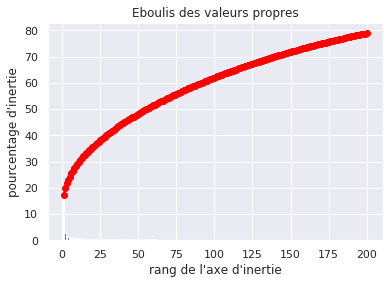

In [20]:
display_scree_plot(preparation_pipeline['dimensionality_reductor'].reductor)

# 2D visualization

In [21]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

In [22]:
X_transformed[:,1]

array([ 0.2471358 , -0.48030473,  0.28160924, ...,  0.22862048,
       -0.46101199,  0.28627628])

In [23]:
print('Binarisation of color categories')
bins = [-np.inf,df_train['TotalPricePerMonth'].quantile(0.25),\
        df_train['TotalPricePerMonth'].quantile(0.50),\
        df_train['TotalPricePerMonth'].quantile(0.75),\
        df_train['TotalPricePerMonth'].quantile(1)]

labels = [0, 1, 2, 3]

df_score_cat_train = pd.cut(df_train['TotalPricePerMonth'], bins=bins, labels=labels)


bins = [-np.inf,df_test['TotalPricePerMonth'].quantile(0.25),\
        df_test['TotalPricePerMonth'].quantile(0.50),\
        df_test['TotalPricePerMonth'].quantile(0.75),\
        df_test['TotalPricePerMonth'].quantile(1)]

labels = [0, 1, 2, 3]

df_score_cat_test = pd.cut(df_test['TotalPricePerMonth'], bins=bins, labels=labels)

Binarisation of color categories


Text(0, 0.5, 'Axe 2')

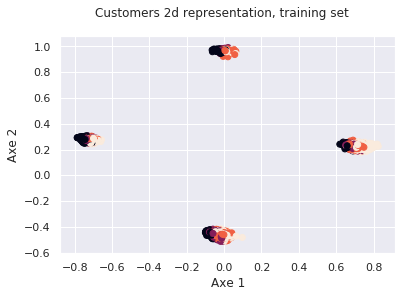

In [24]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [25]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients.html') 

'clusters_plot_clients.html'

Text(0, 0.5, 'Axe 2')

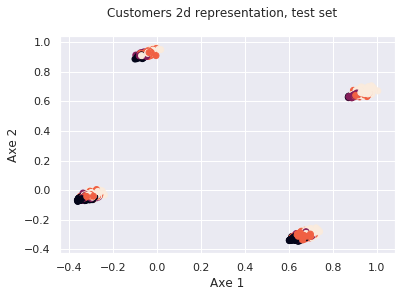

In [26]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

# Model with only bag of word features, PCA

In [185]:
importlib.reload(sys.modules['functions'])
from functions import *

In [186]:
df_train = df_train_ori
df_test = df_test_ori


In [187]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [188]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Fit Dimensionality Reductor
Features selected (in order): Index(['Desc

In [189]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Transform Dimensionality Reductor
Remaining columns: []
Transform Min max scaler multiple


In [190]:
df_train

0         1         2         3         4         5         6  \
0     0.012337  0.471255  0.453895  0.473793  0.422515  0.477429  0.511299   
1     0.356103  0.422611  0.371563  0.401206  0.423753  0.459668  0.244695   
2     0.103371  0.307434  0.409747  0.364878  0.219234  0.380141  0.622568   
3     0.330665  0.428293  0.241569  0.239619  0.325675  0.390270  0.379993   
4     0.073958  0.425343  0.446213  0.538686  0.277486  0.450344  0.462819   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.065726  0.437382  0.430594  0.463784  0.332083  0.577169  0.449719   
4328  0.043881  0.360628  0.483579  0.481299  0.388442  0.438993  0.351419   
4329  0.104478  0.484576  0.220636  0.328119  0.405983  0.524318  0.437660   
4330  0.555281  0.163908  0.491656  0.360686  0.404089  0.404025  0.757682   
4331  0.231274  0.528386  0.659911  0.299427  0.257503  0.494932  0.598595   

             7         8         9        10        11        12        13  \
0     0.621572  0.503608  0.457640  0.488112  0.409851  0.507055  0.489921   
1     0.315718  0.324960  0.332577  0.361417  0.446315  0.447542  0.669783   
2     0.405009  0.446482  0.327183  0.559740  0.570360  0.614771  0.511387   
3     0.644576  0.617557  0.450200  0.457560  0.312062  0.629936  0.598997   
4     0.479767  0.508583  0.404837  0.429034  0.542592  0.385430  0.502766   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.555757  0.531172  0.374963  0.477719  0.642753  0.346193  0.486223   
4328  0.536795  0.537429  0.391859  0.591394  0.484468  0.526235  0.502483   
4329  0.466580  0.276274  0.435515  0.430024  0.562708  0.377260  0.484394   
4330  0.457156  0.857524  0.361941  0.660414  0.087293  0.391632  0.671431   
4331  0.352469  0.151850  0.535111  0.436187  0.214171  0.545815  0.827947   

            14        15        16        17        18        19        20  \
0     0.535112  0.450099  0.416215  0.433678  0.443110  0.493113  0.412216   
1     0.790501  0.482164  0.576499  0.752753  0.562993  0.737260  0.470347   
2     0.560368  0.436389  0.408881  0.598621  0.477201  0.664317  0.351395   
3     0.312526  0.235226  0.519489  0.271736  0.499319  0.317963  0.652768   
4     0.403973  0.552232  0.487449  0.446393  0.348799  0.393461  0.453952   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.347720  0.462146  0.495635  0.567033  0.474786  0.394094  0.429095   
4328  0.474550  0.468647  0.472686  0.449721  0.539173  0.412419  0.513710   
4329  0.659830  0.750543  0.450058  0.538172  0.420419  0.563899  0.377751   
4330  0.717217  0.433293  0.378400  0.609851  0.117578  0.205275  0.773628   
4331  0.320604  0.425448  0.630294  0.438199  0.439825  0.557399  0.391512   

            21        22        23        24        25        26        27  \
0     0.427219  0.473200  0.432093  0.528716  0.450216  0.459646  0.473048   
1     0.526157  0.381711  0.560419  0.457615  0.378896  0.394295  0.411293   
2     0.612083  0.650773  0.406559  0.506455  0.494282  0.547907  0.391580   
3     0.293780  0.557688  0.049582  0.363470  0.553773  0.540428  0.455714   
4     0.371212  0.552085  0.541138  0.432025  0.366758  0.629723  0.628654   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.316267  0.473669  0.458605  0.516340  0.476405  0.469674  0.393134   
4328  0.513390  0.493658  0.516190  0.594272  0.381003  0.435380  0.426950   
4329  0.414882  0.651104  0.378551  0.514956  0.501087  0.460818  0.400513   
4330  0.489875  0.367007  0.308803  0.423619  0.503075  0.363306  0.554256   
4331  0.501134  0.479335  0.252846  0.487499  0.437485  0.555162  0.378684   

            28        29        30        31        32        33        34  \
0     0.433343  0.488316  0.503164  0.400001  0.584752  0.447438  0.492680   
1     0.531512  0.580637  0.551046  0.628213  0.473105  0.278695  0.419523   
2     0.488402  0.535292  0.661

In [191]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

'''
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)
'''

'\ntsne = TSNE(n_components=2, random_state=42)\nX_transformed = tsne.fit_transform(df_train)\nX_test_transformed = tsne.fit_transform(df_test)\n'

Text(0, 0.5, 'Axe 2')

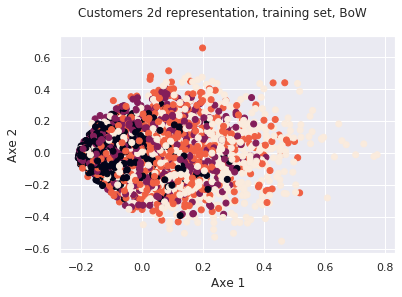

In [192]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

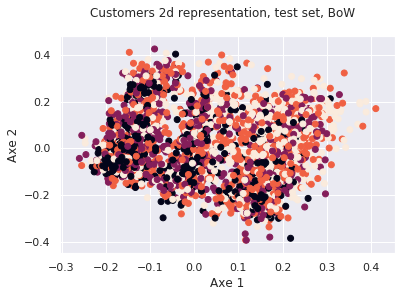

In [193]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [194]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

## Clustering test

In [195]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [196]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [197]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [198]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [199]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

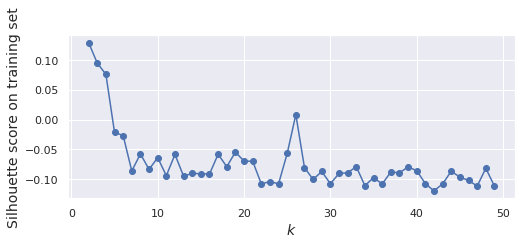

In [200]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

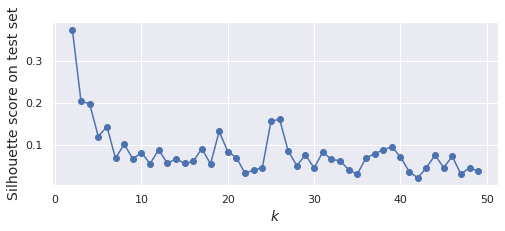

In [201]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [202]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

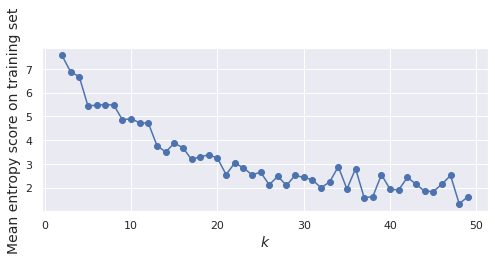

In [203]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

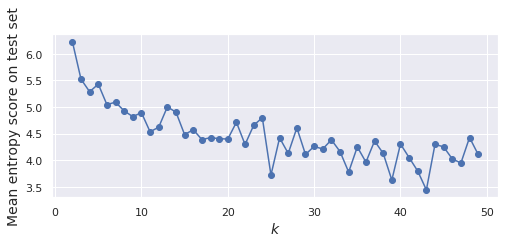

In [204]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : ward

In [205]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [206]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [207]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

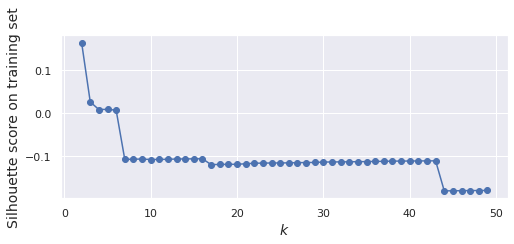

In [208]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [209]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

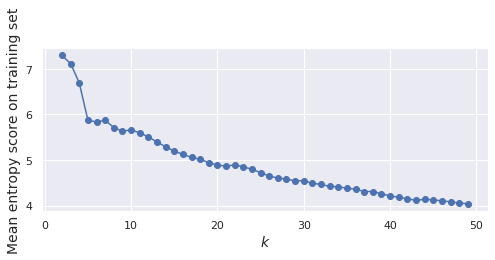

In [210]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with only bag of word features, TSNE

In [211]:
importlib.reload(sys.modules['functions'])
from functions import *

In [212]:
df_train = df_train_ori
df_test = df_test_ori


In [213]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [214]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Fit Dimensionality Reductor
Features selected (in order): Index(['Desc

In [215]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Transform Dimensionality Reductor
Remaining columns: []
Transform Min max scaler multiple


In [216]:
df_train

0         1         2
0     0.783543  0.628913  0.878636
1     0.727786  0.430184  0.704302
2     0.741093  0.560714  0.462285
3     0.648290  0.514565  0.458161
4     0.759664  0.587738  0.564628
...        ...       ...       ...
4327  0.747399  0.632402  0.684291
4328  0.766730  0.647952  0.548147
4329  0.716419  0.469840  0.643490
4330  0.727965  0.528250  0.312737
4331  0.902739  0.582266  0.476758

[4332 rows x 3 columns]

In [217]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

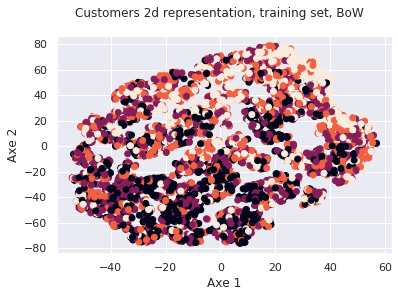

In [218]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

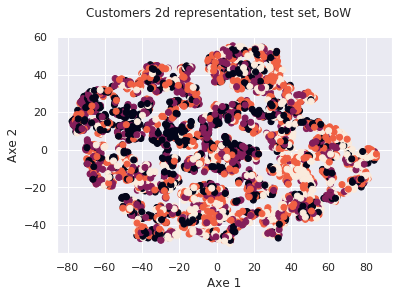

In [219]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [220]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow_TSNE.html') 

'clusters_plot_clients_onlybow_TSNE.html'

## Clustering test

In [221]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [222]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [223]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [224]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [225]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

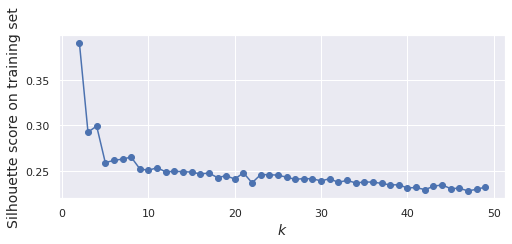

In [226]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

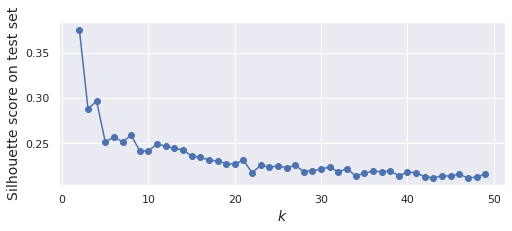

In [227]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [228]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

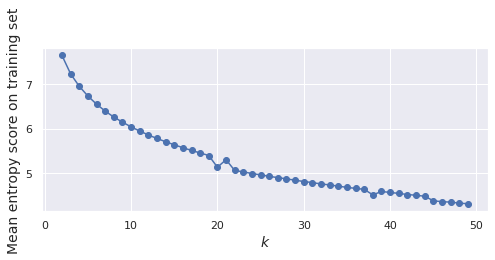

In [229]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

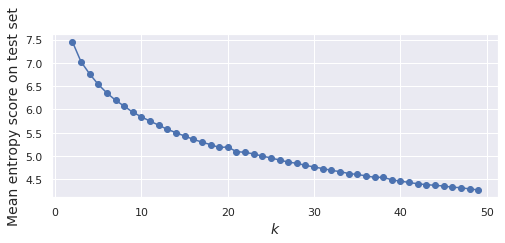

In [230]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : ward

In [231]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [232]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [233]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

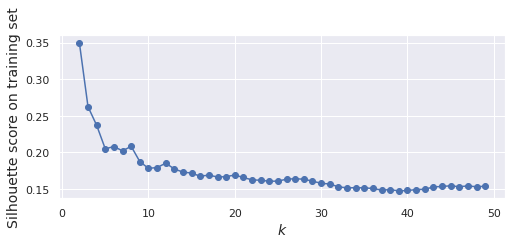

In [234]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [235]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

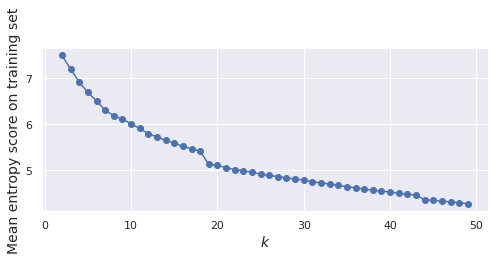

In [236]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with only bow features and TotalPricePerMonth, TSNE

In [293]:
importlib.reload(sys.modules['functions'])
from functions import *

In [294]:
df_train = df_train_ori
df_test = df_test_ori


In [295]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [296]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMonth'],
      dtype='object', length=602)
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNorma

In [297]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMonth'],
      dtype='object', length=602)
Transform Dimensionality Reductor
Remaining columns: ['TotalPricePerMonth']
Transform Min max scaler multiple


In [298]:
df_train

TotalPricePerMonth         0         1         2
0               0.289049  0.783543  0.628913  0.878636
1               0.013128  0.727786  0.430184  0.704302
2               0.004822  0.741093  0.560714  0.462285
3               0.051691  0.648290  0.514565  0.458161
4               0.001098  0.759664  0.587738  0.564628
...                  ...       ...       ...       ...
4327            0.000689  0.747399  0.632402  0.684291
4328            0.000546  0.766730  0.647952  0.548147
4329            0.001672  0.716419  0.469840  0.643490
4330            0.006640  0.727965  0.528250  0.312737
4331            0.010199  0.902739  0.582266  0.476758

[4332 rows x 4 columns]

In [299]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

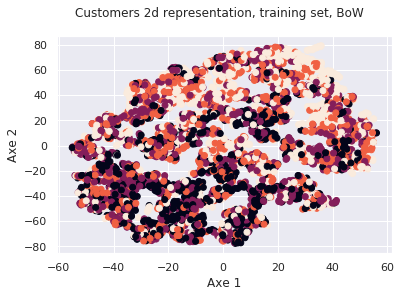

In [300]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

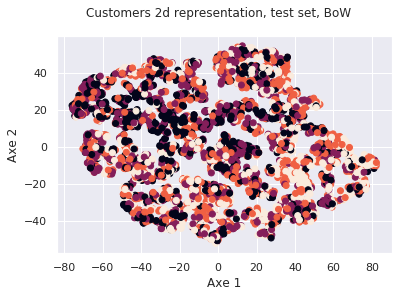

In [301]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [302]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow_TSNE.html') 

'clusters_plot_clients_onlybow_TSNE.html'

## Clustering test

In [303]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [304]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [305]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [306]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [307]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

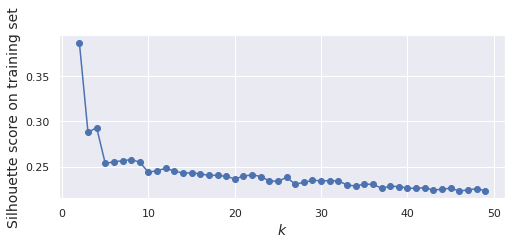

In [308]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

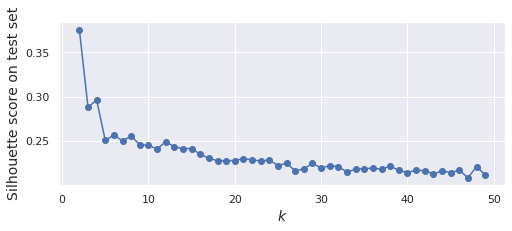

In [309]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [310]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

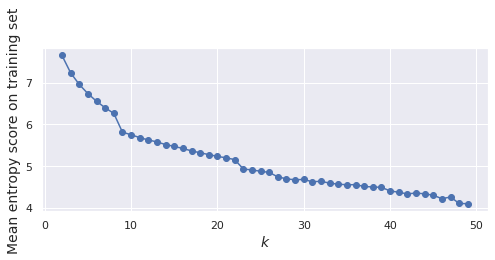

In [311]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

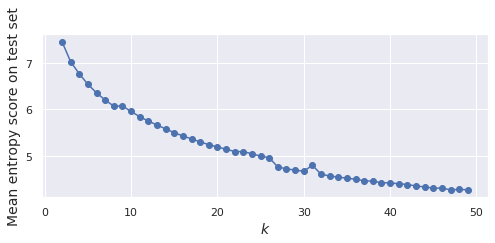

In [312]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : ward

In [313]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [314]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [315]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

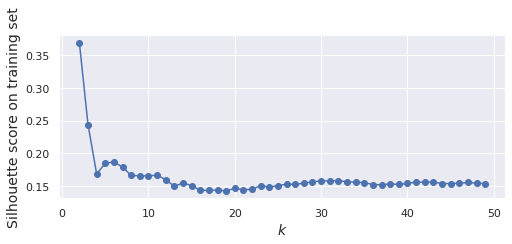

In [316]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [317]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

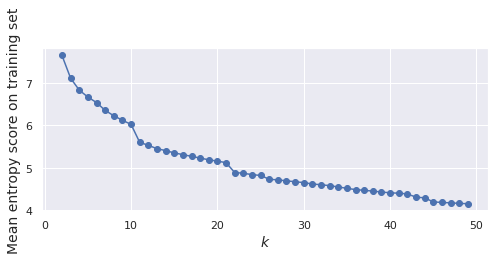

In [318]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with bow features + TotalPricePerMonth

In [35]:
importlib.reload(sys.modules['functions'])
from functions import *

In [36]:
df_train = df_train_ori
df_test = df_test_ori


In [37]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [38]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMonth'],
      dtype='object', length=602)
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNorma

In [39]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMonth'],
      dtype='object', length=602)
Transform Dimensionality Reductor
Remaining columns: ['TotalPricePerMonth']
Transform Min max scaler multiple


In [40]:
df_train

TotalPricePerMonth         0         1         2         3         4  \
0               0.289049  0.012337  0.471255  0.453895  0.473793  0.422515   
1               0.013128  0.356103  0.422611  0.371563  0.401206  0.423753   
2               0.004822  0.103371  0.307434  0.409747  0.364878  0.219234   
3               0.051691  0.330665  0.428293  0.241569  0.239619  0.325675   
4               0.001098  0.073958  0.425343  0.446213  0.538686  0.277486   
...                  ...       ...       ...       ...       ...       ...   
4327            0.000689  0.065726  0.437382  0.430594  0.463784  0.332083   
4328            0.000546  0.043881  0.360628  0.483579  0.481299  0.388442   
4329            0.001672  0.104478  0.484576  0.220636  0.328119  0.405983   
4330            0.006640  0.555281  0.163908  0.491656  0.360686  0.404089   
4331            0.010199  0.231274  0.528386  0.659911  0.299427  0.257503   

             5         6         7         8         9        10        11  \
0     0.477429  0.511299  0.621572  0.503608  0.457640  0.488112  0.409851   
1     0.459668  0.244695  0.315718  0.324960  0.332577  0.361417  0.446315   
2     0.380141  0.622568  0.405009  0.446482  0.327183  0.559740  0.570360   
3     0.390270  0.379993  0.644576  0.617557  0.450200  0.457560  0.312062   
4     0.450344  0.462819  0.479767  0.508583  0.404837  0.429034  0.542592   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.577169  0.449719  0.555757  0.531172  0.374963  0.477719  0.642753   
4328  0.438993  0.351419  0.536795  0.537429  0.391859  0.591394  0.484468   
4329  0.524318  0.437660  0.466580  0.276274  0.435515  0.430024  0.562708   
4330  0.404025  0.757682  0.457156  0.857524  0.361941  0.660414  0.087293   
4331  0.494932  0.598595  0.352469  0.151850  0.535111  0.436187  0.214171   

            12        13        14        15        16        17        18  \
0     0.507055  0.489921  0.535112  0.450099  0.416215  0.433678  0.443110   
1     0.447542  0.669783  0.790501  0.482164  0.576499  0.752753  0.562993   
2     0.614771  0.511387  0.560368  0.436389  0.408881  0.598621  0.477201   
3     0.629936  0.598997  0.312526  0.235226  0.519489  0.271736  0.499319   
4     0.385430  0.502766  0.403973  0.552232  0.487449  0.446393  0.348799   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.346193  0.486223  0.347720  0.462146  0.495635  0.567033  0.474786   
4328  0.526235  0.502483  0.474550  0.468647  0.472686  0.449721  0.539173   
4329  0.377260  0.484394  0.659830  0.750543  0.450058  0.538172  0.420419   
4330  0.391632  0.671431  0.717217  0.433293  0.378400  0.609851  0.117578   
4331  0.545815  0.827947  0.320604  0.425448  0.630294  0.438199  0.439825   

            19        20        21        22        23        24        25  \
0     0.493113  0.412216  0.427219  0.473200  0.432093  0.528716  0.450216   
1     0.737260  0.470347  0.526157  0.381711  0.560419  0.457615  0.378896   
2     0.664317  0.351395  0.612083  0.650773  0.406559  0.506455  0.494282   
3     0.317963  0.652768  0.293780  0.557688  0.049582  0.363470  0.553773   
4     0.393461  0.453952  0.371212  0.552085  0.541138  0.432025  0.366758   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.394094  0.429095  0.316267  0.473669  0.458605  0.516340  0.476405   
4328  0.412419  0.513710  0.513390  0.493658  0.516190  0.594272  0.381003   
4329  0.563899  0.377751  0.414882  0.651104  0.378551  0.514956  0.501087   
4330  0.205275  0.773628  0.489875  0.367007  0.308803  0.423619  0.503075   
4331  0.557399  0.391512  0.501134  0.479335  0.252846  0.487499  0.437485   

            26        27        28        29        30        31        32  \
0     0.459646  0.473048  0.433343  0.488316  0.503164  0.400001  0.584752   
1     0.394295  0.411293  0.531512  0.580637  0.551046  0.628213  0.473105   
2     0.547907  0.391580

In [41]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

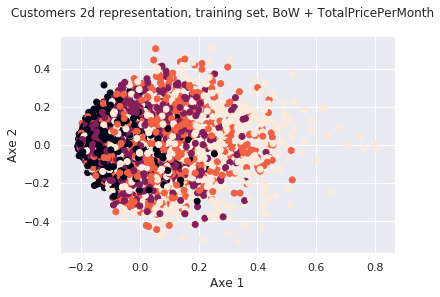

In [42]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW + TotalPricePerMonth')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [43]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with bow features + TotalPricePerMonth + HasEverCancelled

In [44]:
importlib.reload(sys.modules['functions'])
from functions import *

In [45]:
df_train = df_train_ori
df_test = df_test_ori


In [46]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth', 'HasEverCancelled'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [47]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'TotalPricePerMonth'],
      dtype='object', length=603)
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10',

In [48]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'TotalPricePerMonth'],
      dtype='object', length=603)
Transform Dimensionality Reductor
Remaining columns: ['HasEverCancelled', 'TotalPricePerMonth']
Transform Min max scaler multiple


In [49]:
df_train

HasEverCancelled  TotalPricePerMonth         0         1         2  \
0                  1.0            0.289049  0.012337  0.471255  0.453895   
1                  0.0            0.013128  0.356103  0.422611  0.371563   
2                  0.0            0.004822  0.103371  0.307434  0.409747   
3                  0.0            0.051691  0.330665  0.428293  0.241569   
4                  0.0            0.001098  0.073958  0.425343  0.446213   
...                ...                 ...       ...       ...       ...   
4327               0.0            0.000689  0.065726  0.437382  0.430594   
4328               0.0            0.000546  0.043881  0.360628  0.483579   
4329               1.0            0.001672  0.104478  0.484576  0.220636   
4330               0.0            0.006640  0.555281  0.163908  0.491656   
4331               0.0            0.010199  0.231274  0.528386  0.659911   

             3         4         5         6         7         8         9  \
0     0.473793  0.422515  0.477429  0.511299  0.621572  0.503608  0.457640   
1     0.401206  0.423753  0.459668  0.244695  0.315718  0.324960  0.332577   
2     0.364878  0.219234  0.380141  0.622568  0.405009  0.446482  0.327183   
3     0.239619  0.325675  0.390270  0.379993  0.644576  0.617557  0.450200   
4     0.538686  0.277486  0.450344  0.462819  0.479767  0.508583  0.404837   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.463784  0.332083  0.577169  0.449719  0.555757  0.531172  0.374963   
4328  0.481299  0.388442  0.438993  0.351419  0.536795  0.537429  0.391859   
4329  0.328119  0.405983  0.524318  0.437660  0.466580  0.276274  0.435515   
4330  0.360686  0.404089  0.404025  0.757682  0.457156  0.857524  0.361941   
4331  0.299427  0.257503  0.494932  0.598595  0.352469  0.151850  0.535111   

            10        11        12        13        14        15        16  \
0     0.488112  0.409851  0.507055  0.489921  0.535112  0.450099  0.416215   
1     0.361417  0.446315  0.447542  0.669783  0.790501  0.482164  0.576499   
2     0.559740  0.570360  0.614771  0.511387  0.560368  0.436389  0.408881   
3     0.457560  0.312062  0.629936  0.598997  0.312526  0.235226  0.519489   
4     0.429034  0.542592  0.385430  0.502766  0.403973  0.552232  0.487449   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.477719  0.642753  0.346193  0.486223  0.347720  0.462146  0.495635   
4328  0.591394  0.484468  0.526235  0.502483  0.474550  0.468647  0.472686   
4329  0.430024  0.562708  0.377260  0.484394  0.659830  0.750543  0.450058   
4330  0.660414  0.087293  0.391632  0.671431  0.717217  0.433293  0.378400   
4331  0.436187  0.214171  0.545815  0.827947  0.320604  0.425448  0.630294   

            17        18        19        20        21        22        23  \
0     0.433678  0.443110  0.493113  0.412216  0.427219  0.473200  0.432093   
1     0.752753  0.562993  0.737260  0.470347  0.526157  0.381711  0.560419   
2     0.598621  0.477201  0.664317  0.351395  0.612083  0.650773  0.406559   
3     0.271736  0.499319  0.317963  0.652768  0.293780  0.557688  0.049582   
4     0.446393  0.348799  0.393461  0.453952  0.371212  0.552085  0.541138   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.567033  0.474786  0.394094  0.429095  0.316267  0.473669  0.458605   
4328  0.449721  0.539173  0.412419  0.513710  0.513390  0.493658  0.516190   
4329  0.538172  0.420419  0.563899  0.377751  0.414882  0.651104  0.378551   
4330  0.609851  0.117578  0.205275  0.773628  0.489875  0.367007  0.308803   
4331  0.438199  0.439825  0.557399  0.391512  0.501134  0.479335  0.252846   

            24        25        26        27        28        29        30  \
0     0.528716  0.450216  0.459646  0.473048  0.433343  0.488316  0.503164   
1     0.457615  0.378896  0.394295  0.411293  0.531512  0.580637  0.551046   
2     0.506455  0.494282  0.547907  0.391580  0.

In [50]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

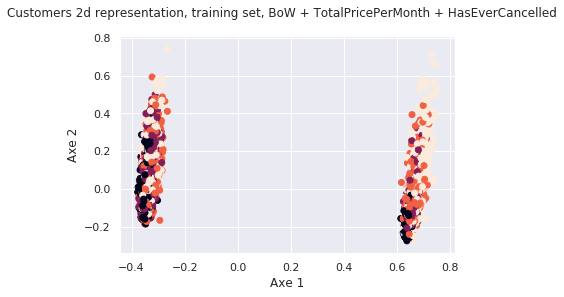

In [51]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW + TotalPricePerMonth + HasEverCancelled')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [52]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with all features and NCA

In [53]:
importlib.reload(sys.modules['functions'])
from functions import *

In [54]:
df_train = df_train_ori
df_test = df_test_ori

In [55]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [56]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [57]:
df_train

HasEverCancelled  TotalPricePerMonth  BoughtTopValueProduct         0  \
0                  1.0            0.877446                    1.0  0.012337   
1                  0.0            0.572415                    1.0  0.356103   
2                  0.0            0.474029                    0.0  0.103371   
3                  0.0            0.707529                    1.0  0.330665   
4                  0.0            0.330609                    0.0  0.073958   
...                ...                 ...                    ...       ...   
4327               0.0            0.286691                    0.0  0.065726   
4328               0.0            0.265155                    0.0  0.043881   
4329               1.0            0.370964                    1.0  0.104478   
4330               0.0            0.505393                    1.0  0.555281   
4331               0.0            0.547572                    0.0  0.231274   

             1         2         3         4         5         6         7  \
0     0.471255  0.453895  0.473793  0.422515  0.477429  0.511299  0.621572   
1     0.422611  0.371563  0.401206  0.423753  0.459668  0.244695  0.315718   
2     0.307434  0.409747  0.364878  0.219234  0.380141  0.622568  0.405009   
3     0.428293  0.241569  0.239619  0.325675  0.390270  0.379993  0.644576   
4     0.425343  0.446213  0.538686  0.277486  0.450344  0.462819  0.479767   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.437382  0.430594  0.463784  0.332083  0.577169  0.449719  0.555757   
4328  0.360628  0.483579  0.481299  0.388442  0.438993  0.351419  0.536795   
4329  0.484576  0.220636  0.328119  0.405983  0.524318  0.437660  0.466580   
4330  0.163908  0.491656  0.360686  0.404089  0.404025  0.757682  0.457156   
4331  0.528386  0.659911  0.299427  0.257503  0.494932  0.598595  0.352469   

             8         9        10        11        12        13        14  \
0     0.503608  0.457640  0.488112  0.409851  0.507055  0.489921  0.535112   
1     0.324960  0.332577  0.361417  0.446315  0.447542  0.669783  0.790501   
2     0.446482  0.327183  0.559740  0.570360  0.614771  0.511387  0.560368   
3     0.617557  0.450200  0.457560  0.312062  0.629936  0.598997  0.312526   
4     0.508583  0.404837  0.429034  0.542592  0.385430  0.502766  0.403973   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.531172  0.374963  0.477719  0.642753  0.346193  0.486223  0.347720   
4328  0.537429  0.391859  0.591394  0.484468  0.526235  0.502483  0.474550   
4329  0.276274  0.435515  0.430024  0.562708  0.377260  0.484394  0.659830   
4330  0.857524  0.361941  0.660414  0.087293  0.391632  0.671431  0.717217   
4331  0.151850  0.535111  0.436187  0.214171  0.545815  0.827947  0.320604   

            15        16        17        18        19        20        21  \
0     0.450099  0.416215  0.433678  0.443110  0.493113  0.412216  0.427219   
1     0.482164  0.576499  0.752753  0.562993  0.737260  0.470347  0.526157   
2     0.436389  0.408881  0.598621  0.477201  0.664317  0.351395  0.612083   
3     0.235226  0.519489  0.271736  0.499319  0.317963  0.652768  0.293780   
4     0.552232  0.487449  0.446393  0.348799  0.393461  0.453952  0.371212   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.462146  0.495635  0.567033  0.474786  0.394094  0.429095  0.316267   
4328  0.468647  0.472686  0.449721  0.539173  0.412419  0.513710  0.513390   
4329  0.750543  0.450058  0.538172  0.420419  0.563899  0.377751  0.414882   
4330  0.433293  0.378400  0.609851  0.117578  0.205275  0.773628  0.489875   
4331  0.425448  0.630294  0.438199  0.439825  0.557399  0.391512  0.501134   

            22        23        24        25        26        27        28  \
0     0.473200  0.432093  0.528716  0.450216  0.459646  0.473048  0.433343   
1     0.381711  0.560419  0.457615  0.378896  0.394295  0.411293  0.531512   
2     0.6507

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, HasEverCancelled to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [59]:
pca = PCA(n_components=2,random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

In [60]:
X_transformed[:,1]

array([ 0.24713579, -0.48030475,  0.28160928, ...,  0.22862045,
       -0.46101208,  0.28627625])

Text(0, 0.5, 'Axe 2')

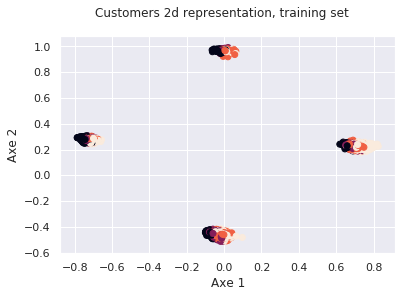

In [61]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [62]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_allfeats.html') 

'clusters_plot_clients_nca_allfeats.html'

# Model with all features and NCA, final representation with tSNE

In [63]:
importlib.reload(sys.modules['functions'])
from functions import *

In [64]:
df_train = df_train_ori
df_test = df_test_ori

In [65]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [66]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [67]:
df_train

HasEverCancelled  TotalPricePerMonth  BoughtTopValueProduct         0  \
0                  1.0            0.877446                    1.0  0.012337   
1                  0.0            0.572415                    1.0  0.356103   
2                  0.0            0.474029                    0.0  0.103371   
3                  0.0            0.707529                    1.0  0.330665   
4                  0.0            0.330609                    0.0  0.073958   
...                ...                 ...                    ...       ...   
4327               0.0            0.286691                    0.0  0.065726   
4328               0.0            0.265155                    0.0  0.043881   
4329               1.0            0.370964                    1.0  0.104478   
4330               0.0            0.505393                    1.0  0.555281   
4331               0.0            0.547572                    0.0  0.231274   

             1         2         3         4         5         6         7  \
0     0.471255  0.453895  0.473793  0.422515  0.477429  0.511299  0.621572   
1     0.422611  0.371563  0.401206  0.423753  0.459668  0.244695  0.315718   
2     0.307434  0.409747  0.364878  0.219234  0.380141  0.622568  0.405009   
3     0.428293  0.241569  0.239619  0.325675  0.390270  0.379993  0.644576   
4     0.425343  0.446213  0.538686  0.277486  0.450344  0.462819  0.479767   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.437382  0.430594  0.463784  0.332083  0.577169  0.449719  0.555757   
4328  0.360628  0.483579  0.481299  0.388442  0.438993  0.351419  0.536795   
4329  0.484576  0.220636  0.328119  0.405983  0.524318  0.437660  0.466580   
4330  0.163908  0.491656  0.360686  0.404089  0.404025  0.757682  0.457156   
4331  0.528386  0.659911  0.299427  0.257503  0.494932  0.598595  0.352469   

             8         9        10        11        12        13        14  \
0     0.503608  0.457640  0.488112  0.409851  0.507055  0.489921  0.535112   
1     0.324960  0.332577  0.361417  0.446315  0.447542  0.669783  0.790501   
2     0.446482  0.327183  0.559740  0.570360  0.614771  0.511387  0.560368   
3     0.617557  0.450200  0.457560  0.312062  0.629936  0.598997  0.312526   
4     0.508583  0.404837  0.429034  0.542592  0.385430  0.502766  0.403973   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.531172  0.374963  0.477719  0.642753  0.346193  0.486223  0.347720   
4328  0.537429  0.391859  0.591394  0.484468  0.526235  0.502483  0.474550   
4329  0.276274  0.435515  0.430024  0.562708  0.377260  0.484394  0.659830   
4330  0.857524  0.361941  0.660414  0.087293  0.391632  0.671431  0.717217   
4331  0.151850  0.535111  0.436187  0.214171  0.545815  0.827947  0.320604   

            15        16        17        18        19        20        21  \
0     0.450099  0.416215  0.433678  0.443110  0.493113  0.412216  0.427219   
1     0.482164  0.576499  0.752753  0.562993  0.737260  0.470347  0.526157   
2     0.436389  0.408881  0.598621  0.477201  0.664317  0.351395  0.612083   
3     0.235226  0.519489  0.271736  0.499319  0.317963  0.652768  0.293780   
4     0.552232  0.487449  0.446393  0.348799  0.393461  0.453952  0.371212   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.462146  0.495635  0.567033  0.474786  0.394094  0.429095  0.316267   
4328  0.468647  0.472686  0.449721  0.539173  0.412419  0.513710  0.513390   
4329  0.750543  0.450058  0.538172  0.420419  0.563899  0.377751  0.414882   
4330  0.433293  0.378400  0.609851  0.117578  0.205275  0.773628  0.489875   
4331  0.425448  0.630294  0.438199  0.439825  0.557399  0.391512  0.501134   

            22        23        24        25        26        27        28  \
0     0.473200  0.432093  0.528716  0.450216  0.459646  0.473048  0.433343   
1     0.381711  0.560419  0.457615  0.378896  0.394295  0.411293  0.531512   
2     0.6507

In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, HasEverCancelled to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [69]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [70]:
X_transformed[:,1]

array([ 10.128316  , -10.440334  ,  -0.33006346, ...,  10.081147  ,
       -16.101868  ,   2.3950124 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

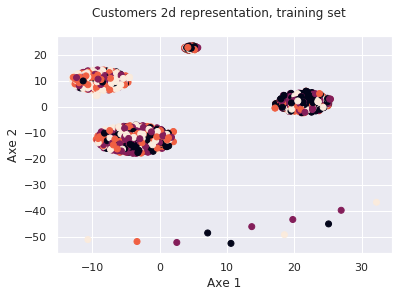

In [71]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [72]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_allfeats_final_tsne.html') 

'clusters_plot_clients_nca_allfeats_final_tsne.html'

# Model with all features and PCA, final representation with tSNE

In [73]:
importlib.reload(sys.modules['functions'])
from functions import *

In [74]:
df_train = df_train_ori
df_test = df_test_ori

In [75]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [76]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [77]:
df_train

HasEverCancelled  TotalPricePerMonth  BoughtTopValueProduct         0  \
0                  1.0            0.877446                    1.0  0.012337   
1                  0.0            0.572415                    1.0  0.356103   
2                  0.0            0.474029                    0.0  0.103371   
3                  0.0            0.707529                    1.0  0.330665   
4                  0.0            0.330609                    0.0  0.073958   
...                ...                 ...                    ...       ...   
4327               0.0            0.286691                    0.0  0.065726   
4328               0.0            0.265155                    0.0  0.043881   
4329               1.0            0.370964                    1.0  0.104478   
4330               0.0            0.505393                    1.0  0.555281   
4331               0.0            0.547572                    0.0  0.231274   

             1         2         3         4         5         6         7  \
0     0.471255  0.453895  0.473793  0.422515  0.477429  0.511299  0.621572   
1     0.422611  0.371563  0.401206  0.423753  0.459668  0.244695  0.315718   
2     0.307434  0.409747  0.364878  0.219234  0.380141  0.622568  0.405009   
3     0.428293  0.241569  0.239619  0.325675  0.390270  0.379993  0.644576   
4     0.425343  0.446213  0.538686  0.277486  0.450344  0.462819  0.479767   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.437382  0.430594  0.463784  0.332083  0.577169  0.449719  0.555757   
4328  0.360628  0.483579  0.481299  0.388442  0.438993  0.351419  0.536795   
4329  0.484576  0.220636  0.328119  0.405983  0.524318  0.437660  0.466580   
4330  0.163908  0.491656  0.360686  0.404089  0.404025  0.757682  0.457156   
4331  0.528386  0.659911  0.299427  0.257503  0.494932  0.598595  0.352469   

             8         9        10        11        12        13        14  \
0     0.503608  0.457640  0.488112  0.409851  0.507055  0.489921  0.535112   
1     0.324960  0.332577  0.361417  0.446315  0.447542  0.669783  0.790501   
2     0.446482  0.327183  0.559740  0.570360  0.614771  0.511387  0.560368   
3     0.617557  0.450200  0.457560  0.312062  0.629936  0.598997  0.312526   
4     0.508583  0.404837  0.429034  0.542592  0.385430  0.502766  0.403973   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.531172  0.374963  0.477719  0.642753  0.346193  0.486223  0.347720   
4328  0.537429  0.391859  0.591394  0.484468  0.526235  0.502483  0.474550   
4329  0.276274  0.435515  0.430024  0.562708  0.377260  0.484394  0.659830   
4330  0.857524  0.361941  0.660414  0.087293  0.391632  0.671431  0.717217   
4331  0.151850  0.535111  0.436187  0.214171  0.545815  0.827947  0.320604   

            15        16        17        18        19        20        21  \
0     0.450099  0.416215  0.433678  0.443110  0.493113  0.412216  0.427219   
1     0.482164  0.576499  0.752753  0.562993  0.737260  0.470347  0.526157   
2     0.436389  0.408881  0.598621  0.477201  0.664317  0.351395  0.612083   
3     0.235226  0.519489  0.271736  0.499319  0.317963  0.652768  0.293780   
4     0.552232  0.487449  0.446393  0.348799  0.393461  0.453952  0.371212   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.462146  0.495635  0.567033  0.474786  0.394094  0.429095  0.316267   
4328  0.468647  0.472686  0.449721  0.539173  0.412419  0.513710  0.513390   
4329  0.750543  0.450058  0.538172  0.420419  0.563899  0.377751  0.414882   
4330  0.433293  0.378400  0.609851  0.117578  0.205275  0.773628  0.489875   
4331  0.425448  0.630294  0.438199  0.439825  0.557399  0.391512  0.501134   

            22        23        24        25        26        27        28  \
0     0.473200  0.432093  0.528716  0.450216  0.459646  0.473048  0.433343   
1     0.381711  0.560419  0.457615  0.378896  0.394295  0.411293  0.531512   
2     0.6507

In [78]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, HasEverCancelled to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [79]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [80]:
X_transformed[:,1]

array([ 10.128316  , -10.440334  ,  -0.33006346, ...,  10.081147  ,
       -16.101868  ,   2.3950124 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

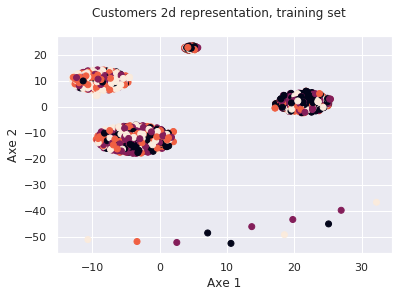

In [81]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [82]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_pca_allfeats_final_tsne.html') 

'clusters_plot_clients_pca_allfeats_final_tsne.html'

# Model with all features and tSNE, final representation with tSNE (2ND BEST)

In [83]:
importlib.reload(sys.modules['functions'])
from functions import *

In [84]:
df_train = df_train_ori
df_test = df_test_ori

In [85]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [86]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [87]:
df_train

HasEverCancelled  TotalPricePerMonth  BoughtTopValueProduct         0  \
0                  1.0            0.877446                    1.0  0.783543   
1                  0.0            0.572415                    1.0  0.727786   
2                  0.0            0.474029                    0.0  0.741093   
3                  0.0            0.707529                    1.0  0.648290   
4                  0.0            0.330609                    0.0  0.759664   
...                ...                 ...                    ...       ...   
4327               0.0            0.286691                    0.0  0.747399   
4328               0.0            0.265155                    0.0  0.766730   
4329               1.0            0.370964                    1.0  0.716419   
4330               0.0            0.505393                    1.0  0.727965   
4331               0.0            0.547572                    0.0  0.902739   

             1         2  
0     0.628913  0.878636  
1     0.430184  0.704302  
2     0.560714  0.462285  
3     0.514565  0.458161  
4     0.587738  0.564628  
...        ...       ...  
4327  0.632402  0.684291  
4328  0.647952  0.548147  
4329  0.469840  0.643490  
4330  0.528250  0.312737  
4331  0.582266  0.476758  

[4332 rows x 6 columns]

In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
HasEverCancelled         4332 non-null float64
TotalPricePerMonth       4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [89]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [90]:
X_transformed[:,1]

array([-12.465547,  20.816553, -38.893944, ...,  -5.508614,  51.804184,
       -56.67659 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

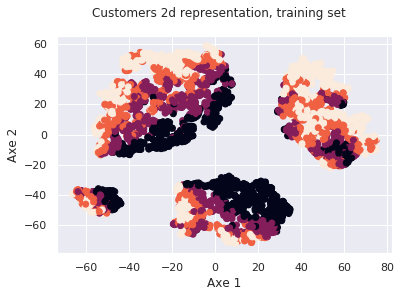

In [91]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [92]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne.html') 

'clusters_plot_clients_sne_allfeats_final_tsne.html'

# Model with all features *except* BoW, and tSNE, final representation with tSNE

In [237]:
importlib.reload(sys.modules['functions'])
from functions import *

In [238]:
df_train = df_train_ori
df_test = df_test_ori

In [239]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    #('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    #('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
    #                                                    algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [240]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Transform log scaler scaler multiple
Transform Min max scaler multiple
Transform Min max scaler multiple


In [252]:
df_train

TotalPricePerMonth  HasEverCancelled  BoughtTopValueProduct
CustomerID                                                             
12346                 0.877446               1.0                    1.0
12347                 0.572415               0.0                    1.0
12348                 0.474029               0.0                    0.0
12349                 0.707529               0.0                    1.0
12350                 0.330609               0.0                    0.0
...                        ...               ...                    ...
18280                 0.286691               0.0                    0.0
18281                 0.265155               0.0                    0.0
18282                 0.370964               1.0                    1.0
18283                 0.505393               0.0                    1.0
18287                 0.547572               0.0                    0.0

[4332 rows x 3 columns]

In [242]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 3 columns):
TotalPricePerMonth       4332 non-null float64
HasEverCancelled         4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
dtypes: float64(3)
memory usage: 135.4+ KB


In [243]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [244]:
X_transformed[:,1]

array([-60.21876  ,  37.987988 ,  21.43146  , ...,  -4.0314097,
        70.640335 ,  29.690075 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

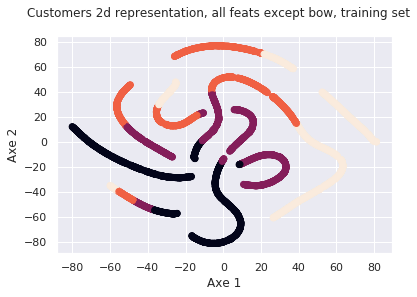

In [245]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, all feats except bow, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

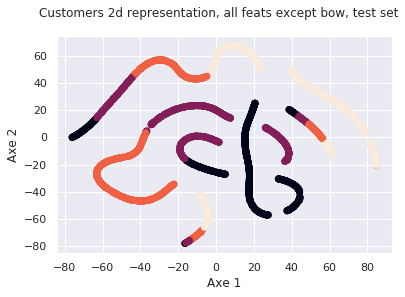

In [253]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, all feats except bow, test set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [260]:
df_train.iloc[:, 0]

CustomerID
12346    0.877446
12347    0.572415
12348    0.474029
12349    0.707529
12350    0.330609
           ...   
18280    0.286691
18281    0.265155
18282    0.370964
18283    0.505393
18287    0.547572
Name: TotalPricePerMonth, Length: 4332, dtype: float64

In [261]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.iloc[:,0], y = df_train.iloc[:,1], z = df_train.iloc[:, 2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatsexceptbow_3d.html') 

'clusters_plot_clients_sne_allfeatsexceptbow_3d.html'

In [265]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.iloc[:,0], y = df_train.iloc[:,1], z = df_train.iloc[:, 2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_train['BoughtTopValueProduct']),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatsexceptbow_3d_color_topvalue.html') 

'clusters_plot_clients_sne_allfeatsexceptbow_3d_color_topvalue.html'

In [266]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.iloc[:,0], y = df_train.iloc[:,1], z = df_train.iloc[:, 2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_train['HasEverCancelled']),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatsexceptbow_3d_color_cancel.html') 

'clusters_plot_clients_sne_allfeatsexceptbow_3d_color_cancel.html'

# Model with all features and tSNE, BoW not apart from the rest, final representation with tSNE

In [112]:
importlib.reload(sys.modules['functions'])
from functions import *

In [113]:
df_train = df_train_ori
df_test = df_test_ori

In [114]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized', 'TotalPricePerMonth', 'HasEverCancelled', 'BoughtTopValueProduct'], \
                                                        algorithm_to_use='TSNE', n_dim=2)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [115]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', '

In [116]:
df_train

0         1
0     0.485951  0.160709
1     0.510417  0.456580
2     0.196422  0.415772
3     0.153005  0.472337
4     0.383346  0.296471
...        ...       ...
4327  0.363371  0.242751
4328  0.280691  0.282607
4329  0.479769  0.431286
4330  0.228942  0.604307
4331  0.701981  0.207829

[4332 rows x 2 columns]

In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
HasEverCancelled         4332 non-null float64
TotalPricePerMonth       4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [89]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [90]:
X_transformed[:,1]

array([-12.465547,  20.816553, -38.893944, ...,  -5.508614,  51.804184,
       -56.67659 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

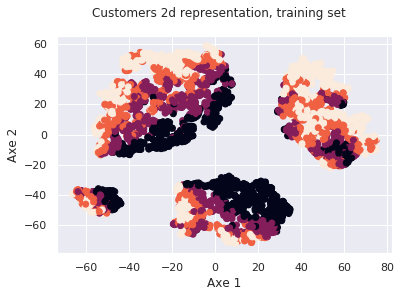

In [91]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [92]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne.html') 

'clusters_plot_clients_sne_allfeats_final_tsne.html'

# Model with all features and tSNE, final representation with tSNE 3D

In [93]:
importlib.reload(sys.modules['functions'])
from functions import *

In [94]:
df_train = df_train_ori
df_test = df_test_ori

In [95]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [96]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [97]:
df_train

HasEverCancelled  TotalPricePerMonth  BoughtTopValueProduct         0  \
0                  1.0            0.877446                    1.0  0.783543   
1                  0.0            0.572415                    1.0  0.727786   
2                  0.0            0.474029                    0.0  0.741093   
3                  0.0            0.707529                    1.0  0.648290   
4                  0.0            0.330609                    0.0  0.759664   
...                ...                 ...                    ...       ...   
4327               0.0            0.286691                    0.0  0.747399   
4328               0.0            0.265155                    0.0  0.766730   
4329               1.0            0.370964                    1.0  0.716419   
4330               0.0            0.505393                    1.0  0.727965   
4331               0.0            0.547572                    0.0  0.902739   

             1         2  
0     0.628913  0.878636  
1     0.430184  0.704302  
2     0.560714  0.462285  
3     0.514565  0.458161  
4     0.587738  0.564628  
...        ...       ...  
4327  0.632402  0.684291  
4328  0.647952  0.548147  
4329  0.469840  0.643490  
4330  0.528250  0.312737  
4331  0.582266  0.476758  

[4332 rows x 6 columns]

In [98]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
HasEverCancelled         4332 non-null float64
TotalPricePerMonth       4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [99]:
tsne = TSNE(n_components=3, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [100]:
X_transformed[:,1]

array([-7.9212937,  3.8351228, -2.1941373, ..., -7.4698176, 13.077991 ,
        4.946701 ], dtype=float32)

In [101]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = X_transformed[:,0], y = X_transformed[:,1], z = X_transformed[:,2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne_3d.html') 

'clusters_plot_clients_sne_allfeats_final_tsne_3d.html'

# Model with bow features + TotalPricePerMonth and NCA, final representation with tSNE

In [102]:
importlib.reload(sys.modules['functions'])
from functions import *

In [103]:
df_train = df_train_ori
df_test = df_test_ori

In [104]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [105]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMo

In [106]:
df_train

TotalPricePerMonth         0         1         2         3         4  \
0               0.877446  0.012337  0.471255  0.453895  0.473793  0.422515   
1               0.572415  0.356103  0.422611  0.371563  0.401206  0.423753   
2               0.474029  0.103371  0.307434  0.409747  0.364878  0.219234   
3               0.707529  0.330665  0.428293  0.241569  0.239619  0.325675   
4               0.330609  0.073958  0.425343  0.446213  0.538686  0.277486   
...                  ...       ...       ...       ...       ...       ...   
4327            0.286691  0.065726  0.437382  0.430594  0.463784  0.332083   
4328            0.265155  0.043881  0.360628  0.483579  0.481299  0.388442   
4329            0.370964  0.104478  0.484576  0.220636  0.328119  0.405983   
4330            0.505393  0.555281  0.163908  0.491656  0.360686  0.404089   
4331            0.547572  0.231274  0.528386  0.659911  0.299427  0.257503   

             5         6         7         8         9        10        11  \
0     0.477429  0.511299  0.621572  0.503608  0.457640  0.488112  0.409851   
1     0.459668  0.244695  0.315718  0.324960  0.332577  0.361417  0.446315   
2     0.380141  0.622568  0.405009  0.446482  0.327183  0.559740  0.570360   
3     0.390270  0.379993  0.644576  0.617557  0.450200  0.457560  0.312062   
4     0.450344  0.462819  0.479767  0.508583  0.404837  0.429034  0.542592   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.577169  0.449719  0.555757  0.531172  0.374963  0.477719  0.642753   
4328  0.438993  0.351419  0.536795  0.537429  0.391859  0.591394  0.484468   
4329  0.524318  0.437660  0.466580  0.276274  0.435515  0.430024  0.562708   
4330  0.404025  0.757682  0.457156  0.857524  0.361941  0.660414  0.087293   
4331  0.494932  0.598595  0.352469  0.151850  0.535111  0.436187  0.214171   

            12        13        14        15        16        17        18  \
0     0.507055  0.489921  0.535112  0.450099  0.416215  0.433678  0.443110   
1     0.447542  0.669783  0.790501  0.482164  0.576499  0.752753  0.562993   
2     0.614771  0.511387  0.560368  0.436389  0.408881  0.598621  0.477201   
3     0.629936  0.598997  0.312526  0.235226  0.519489  0.271736  0.499319   
4     0.385430  0.502766  0.403973  0.552232  0.487449  0.446393  0.348799   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.346193  0.486223  0.347720  0.462146  0.495635  0.567033  0.474786   
4328  0.526235  0.502483  0.474550  0.468647  0.472686  0.449721  0.539173   
4329  0.377260  0.484394  0.659830  0.750543  0.450058  0.538172  0.420419   
4330  0.391632  0.671431  0.717217  0.433293  0.378400  0.609851  0.117578   
4331  0.545815  0.827947  0.320604  0.425448  0.630294  0.438199  0.439825   

            19        20        21        22        23        24        25  \
0     0.493113  0.412216  0.427219  0.473200  0.432093  0.528716  0.450216   
1     0.737260  0.470347  0.526157  0.381711  0.560419  0.457615  0.378896   
2     0.664317  0.351395  0.612083  0.650773  0.406559  0.506455  0.494282   
3     0.317963  0.652768  0.293780  0.557688  0.049582  0.363470  0.553773   
4     0.393461  0.453952  0.371212  0.552085  0.541138  0.432025  0.366758   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.394094  0.429095  0.316267  0.473669  0.458605  0.516340  0.476405   
4328  0.412419  0.513710  0.513390  0.493658  0.516190  0.594272  0.381003   
4329  0.563899  0.377751  0.414882  0.651104  0.378551  0.514956  0.501087   
4330  0.205275  0.773628  0.489875  0.367007  0.308803  0.423619  0.503075   
4331  0.557399  0.391512  0.501134  0.479335  0.252846  0.487499  0.437485   

            26        27        28        29        30        31        32  \
0     0.459646  0.473048  0.433343  0.488316  0.503164  0.400001  0.584752   
1     0.394295  0.411293  0.531512  0.580637  0.551046  0.628213  0.473105   
2     0.547907  0.391580

In [107]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 201 entries, TotalPricePerMonth to 199
dtypes: float64(201)
memory usage: 6.6 MB


In [108]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [109]:
X_transformed[:,1]

array([ -3.402222 ,  -1.4547541, -14.010796 , ...,   6.6002717,
       -47.472893 ,  -1.363583 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

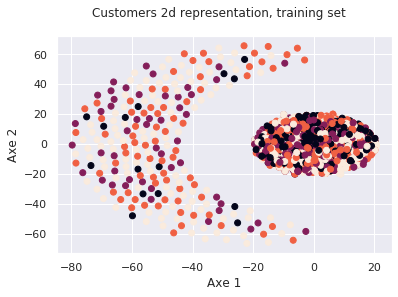

In [110]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [111]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_bowandtotalpricepermonthfeats_final_tsne.html') 

'clusters_plot_clients_nca_bowandtotalpricepermonthfeats_final_tsne.html'

# Model with tSNE, then clustering algorithm KMeans

In [138]:
importlib.reload(sys.modules['functions'])
from functions import *

In [123]:
df_train = df_train_ori
df_test = df_test_ori

In [124]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [125]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [126]:
df_train

HasEverCancelled  TotalPricePerMonth  BoughtTopValueProduct         0  \
0                  1.0            0.877446                    1.0  0.783543   
1                  0.0            0.572415                    1.0  0.727786   
2                  0.0            0.474029                    0.0  0.741093   
3                  0.0            0.707529                    1.0  0.648290   
4                  0.0            0.330609                    0.0  0.759664   
...                ...                 ...                    ...       ...   
4327               0.0            0.286691                    0.0  0.747399   
4328               0.0            0.265155                    0.0  0.766730   
4329               1.0            0.370964                    1.0  0.716419   
4330               0.0            0.505393                    1.0  0.727965   
4331               0.0            0.547572                    0.0  0.902739   

             1         2  
0     0.628913  0.878636  
1     0.430184  0.704302  
2     0.560714  0.462285  
3     0.514565  0.458161  
4     0.587738  0.564628  
...        ...       ...  
4327  0.632402  0.684291  
4328  0.647952  0.548147  
4329  0.469840  0.643490  
4330  0.528250  0.312737  
4331  0.582266  0.476758  

[4332 rows x 6 columns]

In [129]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [130]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [131]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [135]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [163]:
gini_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    gini_sum = 0
    for unique_label in unique_labels:
        gini_sum += gini(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    gini_sum = gini_sum / len(unique_labels)
    
    gini_mean_score_per_k_train.append(gini_sum)

    
gini_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    gini_sum = 0
    for unique_label in unique_labels:
        gini_sum += gini(df_test['TotalPricePerMonth'][labels_test == unique_label].to_numpy())
        
    gini_sum = gini_sum / len(unique_labels)
    
    gini_mean_score_per_k_test.append(gini_sum)    
    

In [210]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['TotalPricePerMonth'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

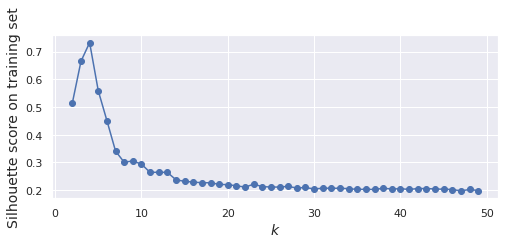

In [133]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

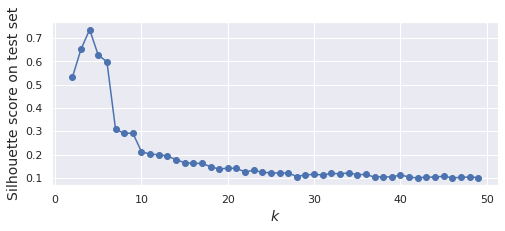

In [136]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [214]:
print('Gini before clustering :')
gini(df_train['TotalPricePerMonth'].to_numpy())

Gini before clustering :


0.14231138191824186

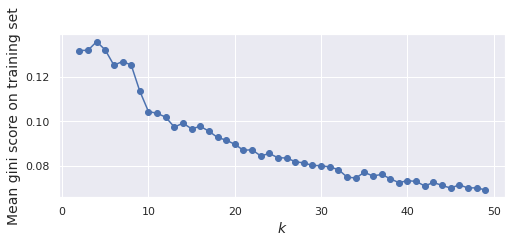

In [166]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), gini_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean gini score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

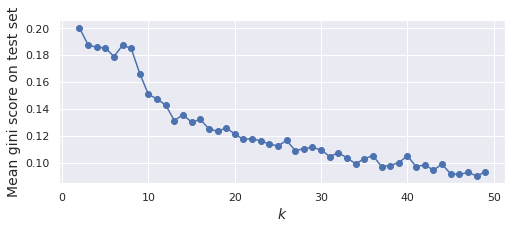

In [167]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), gini_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean gini score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [209]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

8.340339103018163

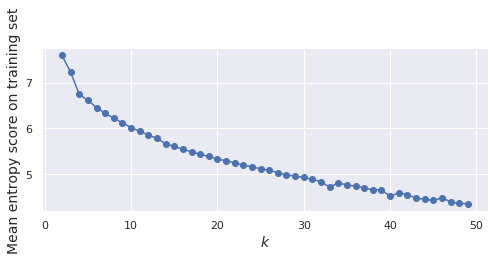

In [215]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

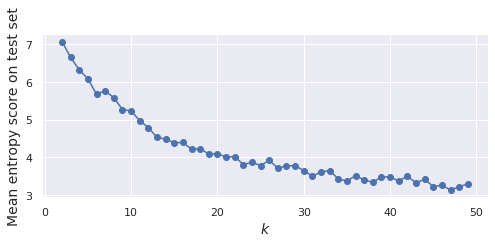

In [216]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with tSNE, then clustering algorithm Ward
No visualisation on test set because AgglomerativeClustering has no predict function, only fit_predict

In [168]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [170]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [171]:
gini_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    gini_sum = 0
    for unique_label in unique_labels:
        gini_sum += gini(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    gini_sum = gini_sum / len(unique_labels)
    
    gini_mean_score_per_k_train.append(gini_sum)


    

In [217]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

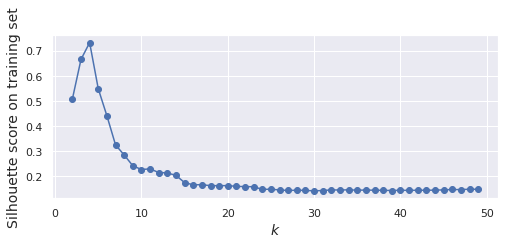

In [172]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

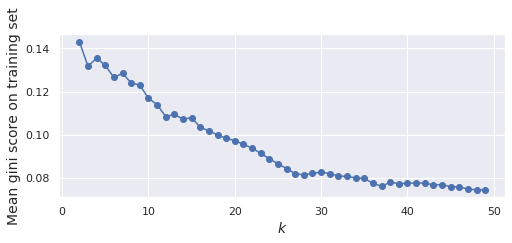

In [173]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), gini_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean gini score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [221]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

Entropy before clustering :


8.340339103018163

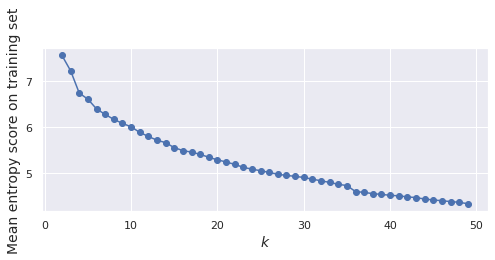

In [219]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with tSNE, then clustering algorithm Ward, distance threshold
No visualisation on test set because AgglomerativeClustering has no predict function, only fit_predict

In [253]:
np.unique(AgglomerativeClustering(distance_threshold=1, n_clusters=None, affinity='euclidean').fit(df_train).labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55])

In [271]:
clusterer_ward_per_thr = [AgglomerativeClustering(distance_threshold=thr, n_clusters=None, affinity='euclidean').fit(df_train) for thr in reversed(range(0,12))]

In [234]:
np.unique(clusterer_ward.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [262]:
clusterer_ward_per_thr

[]

In [272]:
entropy_mean_score_per_k_train = []

for model in clusterer_ward_per_thr[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

/home/francois/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning:

invalid value encountered in true_divide



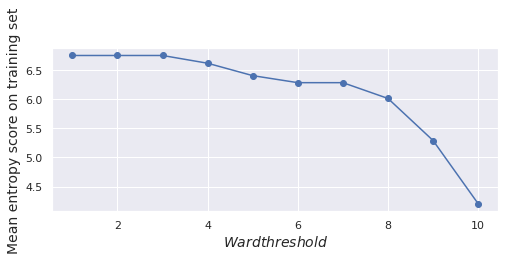

In [276]:
plt.figure(figsize=(8, 3))
plt.plot(range(1,12), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$Ward threshold$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# => Around 50 clusters => entropy of TotalPrice around 4.5

# Prepation model with LLE reduce to 200, then clustering algorithm Ward

In [280]:
importlib.reload(sys.modules['functions'])
from functions import *

In [281]:
df_train = df_train_ori
df_test = df_test_ori


In [282]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=200, n_neighbors=10)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [283]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [284]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Transform log scaler scaler multiple
Transform Min max scaler multiple
Transform Dimensionality Reductor
Remaining columns: ['HasEverCancelled', 'TotalPricePerMonth', 'BoughtTopValueProduct']
Transform Min max scaler multiple


In [285]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [ ]:
labels_test_per_k = [model.predict(df_test) for model in clusterer_per_k[1:]]

In [286]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [291]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [287]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

In [292]:
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['TotalPricePerMonth'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    

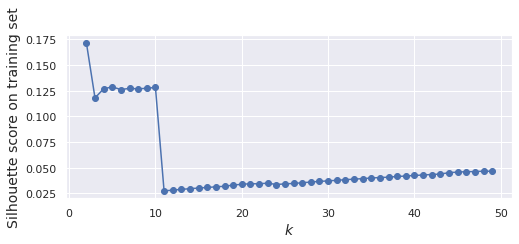

In [288]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

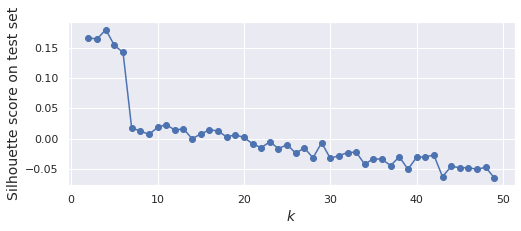

In [293]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [289]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

Entropy before clustering :


8.340339103018163

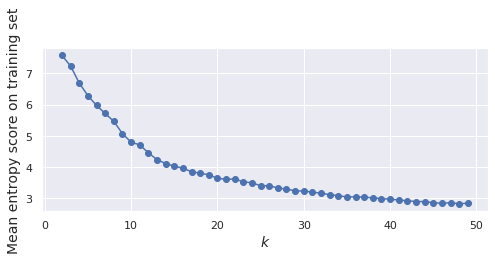

In [290]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

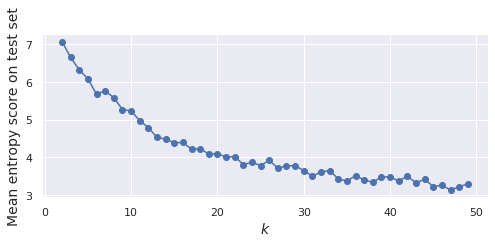

In [294]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Prepation model with LLE reduce to 3, then clustering algorithm Ward

In [45]:
importlib.reload(sys.modules['functions'])
from functions import *

In [46]:
df_train = df_train_ori
df_test = df_test_ori


In [47]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=3, n_neighbors=10)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [48]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [49]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Transform log scaler scaler multiple
Transform Min max scaler multiple
Transform Dimensionality Reductor
Remaining columns: ['BoughtTopValueProduct', 'TotalPricePerMonth', 'HasEverCancelled']
Transform Min max scaler multiple


In [50]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [53]:
labels_test_per_k = [model.predict(df_test) for model in clusterer_per_k[1:]]

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

In [54]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [52]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

NameError: name 'labels_test_per_k' is not defined

In [55]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

In [ ]:
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['TotalPricePerMonth'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    

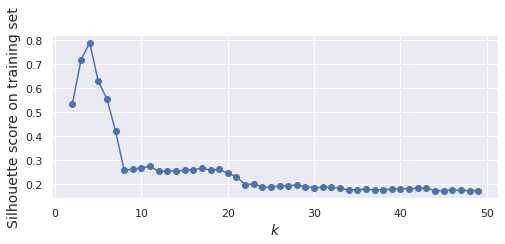

In [56]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [57]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

Entropy before clustering :


8.340339103018163

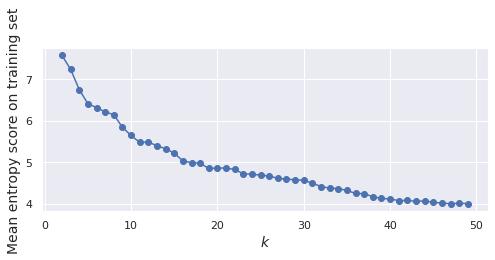

In [58]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Preparation model BoW feats only, then LLE reduce to 200, then KMeans and Ward

In [80]:
importlib.reload(sys.modules['functions'])
from functions import *

In [81]:
df_train = df_train_ori
df_test = df_test_ori


In [82]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=200, n_neighbors=10)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [83]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Fit Dimensionality Reductor
Features selected (in order): Index(['Desc

In [84]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Transform Dimensionality Reductor
Remaining columns: []
Transform Min max scaler multiple


In [85]:
df_train

0         1         2         3         4         5         6  \
0     0.070266  0.866875  0.713318  0.460115  0.863221  0.431550  0.536350   
1     0.156365  0.579371  0.478420  0.707986  0.661040  0.454051  0.570945   
2     0.161355  0.632033  0.498368  0.791762  0.631296  0.565009  0.560440   
3     0.116654  0.558755  0.487852  0.703197  0.678159  0.379200  0.617604   
4     0.215421  0.637681  0.421959  0.846181  0.705704  0.307077  0.630998   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.827676  0.853398  0.369199  0.697179  0.590485  0.333221  0.212182   
4328  0.071993  0.693057  0.489952  0.853455  0.603962  0.389066  0.469962   
4329  0.229847  0.208244  0.769806  0.763834  0.641421  0.621625  0.683999   
4330  0.140146  0.617572  0.502182  0.783047  0.671382  0.403092  0.547635   
4331  0.139803  0.638857  0.481960  0.675371  0.670384  0.344563  0.528933   

             7         8         9        10        11        12        13  \
0     0.812617  0.342428  0.923869  0.577394  0.179362  0.770566  0.314765   
1     0.788447  0.472721  0.720127  0.574795  0.197042  0.730587  0.348650   
2     0.793859  0.469092  0.714410  0.556187  0.192830  0.746765  0.314391   
3     0.804108  0.430118  0.731471  0.575446  0.194461  0.751565  0.295617   
4     0.797553  0.410153  0.736959  0.636951  0.182717  0.749683  0.301199   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.776894  0.584255  0.714071  0.645857  0.192477  0.751183  0.378630   
4328  0.797395  0.474349  0.717087  0.598267  0.188626  0.754960  0.327969   
4329  0.794013  0.468698  0.708608  0.547027  0.213978  0.774716  0.330156   
4330  0.789021  0.475740  0.727101  0.580177  0.202781  0.731360  0.320507   
4331  0.813792  0.567276  0.725081  0.522198  0.230844  0.718558  0.327512   

            14        15        16        17        18        19        20  \
0     0.100587  0.430214  0.017869  0.295874  0.826286  0.371261  0.973674   
1     0.093863  0.446614  0.014503  0.313362  0.818329  0.353243  0.949206   
2     0.091993  0.445639  0.014178  0.382740  0.844512  0.328722  0.942916   
3     0.097561  0.421157  0.017349  0.389736  0.799655  0.349649  0.908984   
4     0.088279  0.389272  0.014508  0.321823  0.848739  0.381229  0.942832   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.068136  0.462686  0.015401  0.310551  0.940744  0.311877  0.970922   
4328  0.085962  0.444178  0.013358  0.268448  0.894573  0.285826  0.955623   
4329  0.105268  0.431842  0.007908  0.282008  0.749205  0.351332  0.963414   
4330  0.095285  0.430108  0.015518  0.345939  0.815351  0.346536  0.943248   
4331  0.094627  0.441559  0.017846  0.363104  0.893536  0.339122  0.947182   

            21        22        23        24        25        26        27  \
0     0.250333  0.650744  0.642150  0.814737  0.613729  0.580238  0.393253   
1     0.346848  0.613328  0.670994  0.743037  0.594862  0.521146  0.529247   
2     0.355365  0.550963  0.740861  0.754683  0.557007  0.312051  0.436997   
3     0.358930  0.563987  0.684251  0.716123  0.560773  0.520379  0.504374   
4     0.515936  0.647522  0.739552  0.699624  0.401874  0.515131  0.489046   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.380201  0.729425  0.821431  0.740277  0.454762  0.587593  0.579322   
4328  0.351814  0.657754  0.477676  0.764978  0.425704  0.528625  0.547920   
4329  0.350360  0.689863  0.683038  0.753399  0.544260  0.709908  0.567566   
4330  0.343257  0.585348  0.680851  0.738126  0.559893  0.494416  0.510511   
4331  0.377296  0.599356  0.689075  0.771135  0.487873  0.514710  0.509210   

            28        29        30        31        32        33        34  \
0     0.927041  0.613220  0.136785  0.615248  0.263532  0.900667  0.757752   
1     0.598224  0.316217  0.497287  0.470563  0.444874  0.377664  0.742559   
2     0.599991  0.282848  0.615

In [86]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [87]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [88]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [89]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [90]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

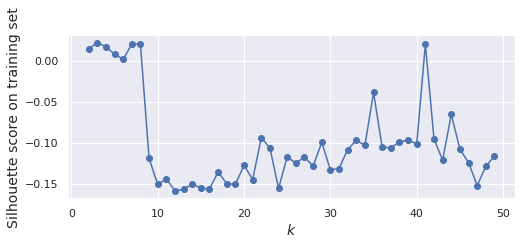

In [91]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

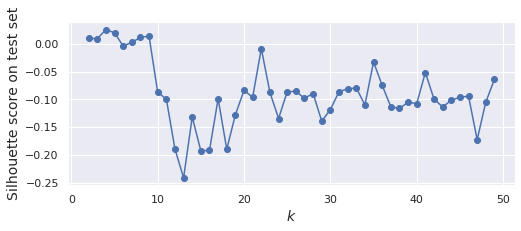

In [92]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [93]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

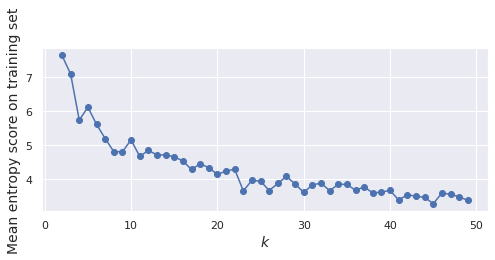

In [94]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

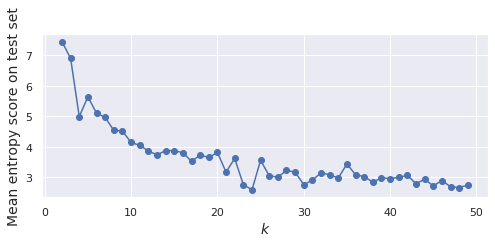

In [95]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : Ward

In [96]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [97]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [99]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

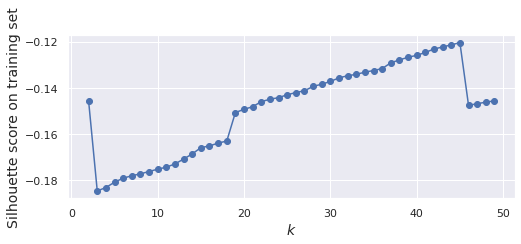

In [100]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [101]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

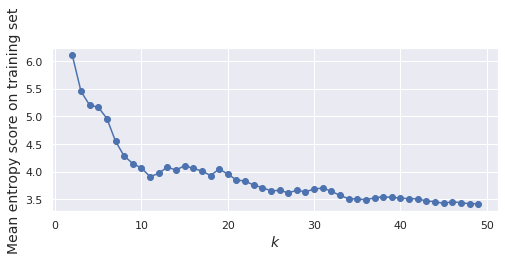

In [102]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Preparation model BoW feats only, then LLE reduce to 3 then KMeans and Ward

In [126]:
importlib.reload(sys.modules['functions'])
from functions import *

In [104]:
df_train = df_train_ori
df_test = df_test_ori


In [105]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=3, n_neighbors=10)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [106]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Fit Dimensionality Reductor
Features selected (in order): Index(['Desc

In [107]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Transform Dimensionality Reductor
Remaining columns: []
Transform Min max scaler multiple


In [108]:
df_train

0         1         2
0     0.929734  0.133125  0.286682
1     0.843635  0.420629  0.521580
2     0.838645  0.367967  0.501632
3     0.883346  0.441245  0.512148
4     0.784579  0.362319  0.578041
...        ...       ...       ...
4327  0.172324  0.146602  0.630801
4328  0.928007  0.306943  0.510048
4329  0.770153  0.791756  0.230194
4330  0.859854  0.382429  0.497818
4331  0.860197  0.361143  0.518040

[4332 rows x 3 columns]

In [109]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [110]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [111]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [112]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [113]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

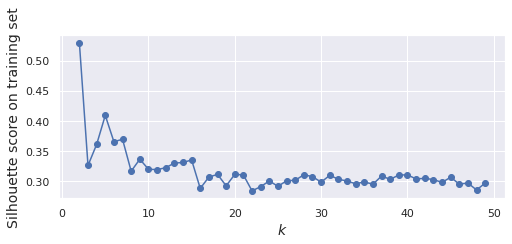

In [114]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

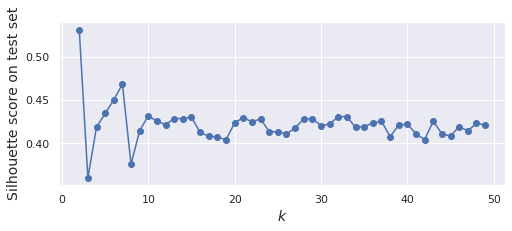

In [115]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [116]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

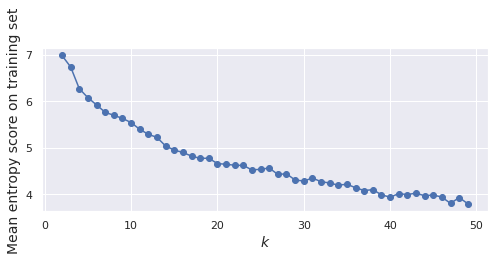

In [117]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

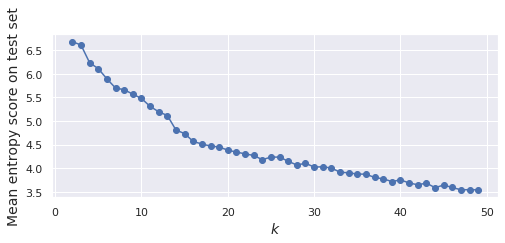

In [118]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : ward

In [119]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [120]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [121]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

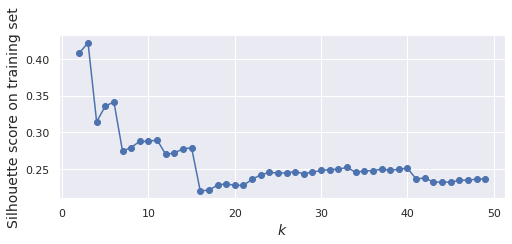

In [122]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [123]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

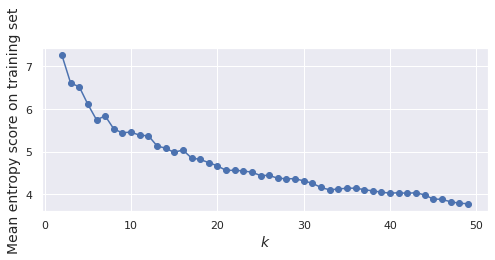

In [124]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Plot representation

In [131]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.loc[:,0], y = df_train.loc[:,1], z = df_train.loc[:,2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = series_total_price_per_month_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_lle_bowfeats_3d.html') 

'clusters_plot_clients_lle_bowfeats_3d.html'

# Model with 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency', 'HasEverCancelled', 'BoughtTopValueProduct', 'DescriptionNormalized', and TSNE, with KMeans (INTERESTING)

In [182]:
importlib.reload(sys.modules['functions'])
from functions import *

In [183]:
df_train = df_train_ori
df_test = df_test_ori

In [184]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency', 'HasEverCancelled', 'BoughtTopValueProduct', 'DescriptionNormalized'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [185]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'Recency', 'TotalPricePerMonth',
       'TotalQuantityPerMonth'],
      dtype='object', length=606)
Fit log scaler multiple
Transform log scaler scaler m

In [186]:
rfm_scores_train = get_rfm_scores(df_train)

In [187]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [188]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [189]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [190]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RFMScore, Length: 4332, dtype: int64

In [191]:
rfm_scores_train

0       311
1       411
2       412
3       111
4       344
       ... 
4327    344
4328    244
4329    244
4330    422
4331    211
Name: RFMScore, Length: 4332, dtype: object

In [192]:
df_train

Recency  TotalQuantityPerMonth  HasEverCancelled  \
0     0.932971               0.915344               1.0   
1     0.991722               0.536506               0.0   
2     0.979372               0.543549               0.0   
3     0.000000               0.657517               0.0   
4     0.909797               0.299590               0.0   
...        ...                    ...               ...   
4327  0.856316               0.171885               0.0   
4328  0.655912               0.233494               0.0   
4329  0.498845               0.319077               1.0   
4330  0.950265               0.484163               0.0   
4331  0.706200               0.553078               0.0   

      BoughtTopValueProduct  TotalPricePerMonth         0         1         2  
0                       1.0            0.877446  0.783543  0.628913  0.878636  
1                       1.0            0.572415  0.727786  0.430184  0.704302  
2                       0.0            0.474029  0.741093  0.560714  0.462285  
3                       1.0            0.707529  0.648290  0.514565  0.458161  
4                       0.0            0.330609  0.759664  0.587738  0.564628  
...                     ...                 ...       ...       ...       ...  
4327                    0.0            0.286691  0.747399  0.632402  0.684291  
4328                    0.0            0.265155  0.766730  0.647952  0.548147  
4329                    1.0            0.370964  0.716419  0.469840  0.643490  
4330                    1.0            0.505393  0.727965  0.528250  0.312737  
4331                    0.0            0.547572  0.902739  0.582266  0.476758  

[4332 rows x 8 columns]

In [193]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 8 columns):
Recency                  4332 non-null float64
TotalQuantityPerMonth    4332 non-null float64
HasEverCancelled         4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
TotalPricePerMonth       4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(8)
memory usage: 270.9 KB


In [194]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [195]:
X_transformed[:,1]

array([  2.6228526,  29.104588 , -65.24375  , ..., -29.51727  ,
        36.627422 , -54.926    ], dtype=float32)

Text(0, 0.5, 'Axe 2')

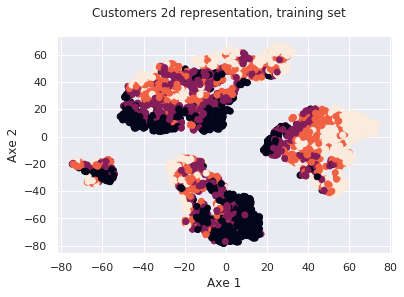

In [196]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [197]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatswithRFM_final_tsne.html') 

'clusters_plot_clients_sne_allfeatswithRFM_final_tsne.html'

Text(0, 0.5, 'Axe 2')

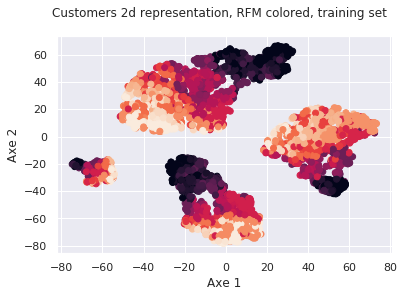

In [198]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [199]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatswithRFM_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_allfeatswithRFM_color_RFM_final_tsne.html'

## RFM and bow (without BoughtTopValueProduct and HasEverCancelled)

In [168]:
df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 0, 1, 2]]

TotalPricePerMonth   Recency  TotalQuantityPerMonth         0         1  \
0               0.877446  0.932971               0.915344  0.783543  0.628913   
1               0.572415  0.991722               0.536506  0.727786  0.430184   
2               0.474029  0.979372               0.543549  0.741093  0.560714   
3               0.707529  0.000000               0.657517  0.648290  0.514565   
4               0.330609  0.909797               0.299590  0.759664  0.587738   
...                  ...       ...                    ...       ...       ...   
4327            0.286691  0.856316               0.171885  0.747399  0.632402   
4328            0.265155  0.655912               0.233494  0.766730  0.647952   
4329            0.370964  0.498845               0.319077  0.716419  0.469840   
4330            0.505393  0.950265               0.484163  0.727965  0.528250   
4331            0.547572  0.706200               0.553078  0.902739  0.582266   

             2  
0     0.878636  
1     0.704302  
2     0.462285  
3     0.458161  
4     0.564628  
...        ...  
4327  0.684291  
4328  0.548147  
4329  0.643490  
4330  0.312737  
4331  0.476758  

[4332 rows x 6 columns]

In [169]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 0, 1, 2]])
X_test_transformed = tsne.fit_transform(df_test[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 0, 1, 2]])

In [170]:
X_transformed[:,1]

array([ 63.194237,  -6.357803,  37.56004 , ..., -11.643651,  45.900055,
        36.52802 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

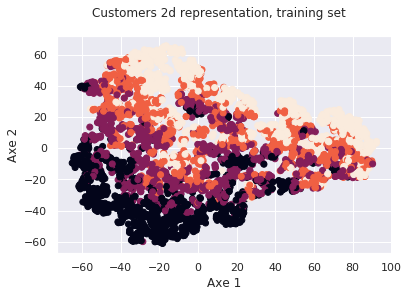

In [171]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [172]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_bowandRfm_final_tsne.html') 

'clusters_plot_clients_sne_bowandRfm_final_tsne.html'

Text(0, 0.5, 'Axe 2')

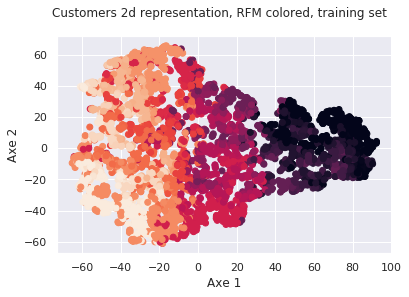

In [173]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

## RFM and bow (without HasEverCancelled, but WITH BoughtTopValueProduct)

In [210]:
df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 0, 1, 2]]

TotalPricePerMonth   Recency  TotalQuantityPerMonth  \
0               0.877446  0.932971               0.915344   
1               0.572415  0.991722               0.536506   
2               0.474029  0.979372               0.543549   
3               0.707529  0.000000               0.657517   
4               0.330609  0.909797               0.299590   
...                  ...       ...                    ...   
4327            0.286691  0.856316               0.171885   
4328            0.265155  0.655912               0.233494   
4329            0.370964  0.498845               0.319077   
4330            0.505393  0.950265               0.484163   
4331            0.547572  0.706200               0.553078   

      BoughtTopValueProduct         0         1         2  
0                       1.0  0.783543  0.628913  0.878636  
1                       1.0  0.727786  0.430184  0.704302  
2                       0.0  0.741093  0.560714  0.462285  
3                       1.0  0.648290  0.514565  0.458161  
4                       0.0  0.759664  0.587738  0.564628  
...                     ...       ...       ...       ...  
4327                    0.0  0.747399  0.632402  0.684291  
4328                    0.0  0.766730  0.647952  0.548147  
4329                    1.0  0.716419  0.469840  0.643490  
4330                    1.0  0.727965  0.528250  0.312737  
4331                    0.0  0.902739  0.582266  0.476758  

[4332 rows x 7 columns]

In [211]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 0, 1, 2]])
X_test_transformed = tsne.fit_transform(df_test[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 0, 1, 2]])

In [212]:
X_transformed[:,1]

array([ 68.24322 ,  30.58995 , -60.437893, ...,  11.125152,  65.72598 ,
       -63.495106], dtype=float32)

Text(0, 0.5, 'Axe 2')

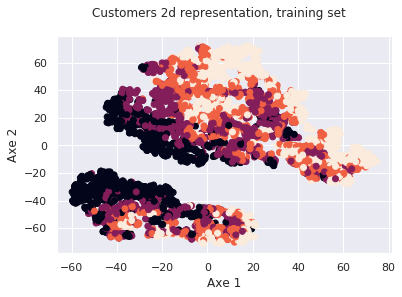

In [213]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [214]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_bowandRfmandboughttopvalue_final_tsne.html') 

'clusters_plot_clients_sne_bowandRfmandboughttopvalue_final_tsne.html'

Text(0, 0.5, 'Axe 2')

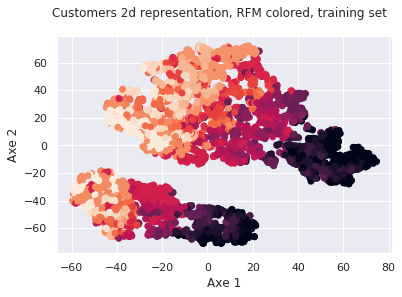

In [215]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

## RFM only (without bow, BoughtTopValueProduct and HasEverCancelled)

In [174]:
df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth']]

TotalPricePerMonth   Recency  TotalQuantityPerMonth
0               0.877446  0.932971               0.915344
1               0.572415  0.991722               0.536506
2               0.474029  0.979372               0.543549
3               0.707529  0.000000               0.657517
4               0.330609  0.909797               0.299590
...                  ...       ...                    ...
4327            0.286691  0.856316               0.171885
4328            0.265155  0.655912               0.233494
4329            0.370964  0.498845               0.319077
4330            0.505393  0.950265               0.484163
4331            0.547572  0.706200               0.553078

[4332 rows x 3 columns]

In [204]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth']])
X_test_transformed = tsne.fit_transform(df_test[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth']])

In [205]:
X_transformed[:,1]

array([ 64.5019  ,  62.6094  ,  49.83136 , ..., -35.8076  ,  35.60723 ,
         4.498776], dtype=float32)

Text(0, 0.5, 'Axe 2')

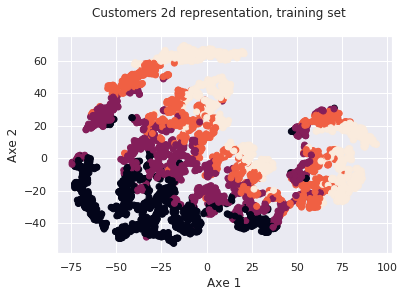

In [206]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [207]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_rfmOnly_final_tsne.html') 

'clusters_plot_clients_sne_rfmOnly_final_tsne.html'

Text(0, 0.5, 'Axe 2')

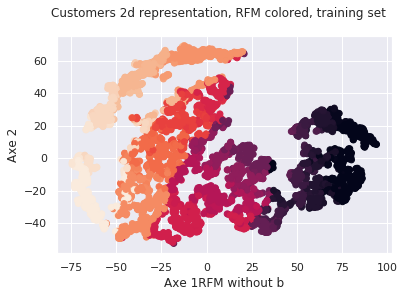

In [208]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1RFM without b')
plt.ylabel("Axe 2")

#plt.yscale('log')

# RFM with 'TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled' (GOOD)

In [187]:
df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled']]

TotalPricePerMonth   Recency  TotalQuantityPerMonth  \
0               0.877446  0.932971               0.915344   
1               0.572415  0.991722               0.536506   
2               0.474029  0.979372               0.543549   
3               0.707529  0.000000               0.657517   
4               0.330609  0.909797               0.299590   
...                  ...       ...                    ...   
4327            0.286691  0.856316               0.171885   
4328            0.265155  0.655912               0.233494   
4329            0.370964  0.498845               0.319077   
4330            0.505393  0.950265               0.484163   
4331            0.547572  0.706200               0.553078   

      BoughtTopValueProduct  HasEverCancelled  
0                       1.0               1.0  
1                       1.0               0.0  
2                       0.0               0.0  
3                       1.0               0.0  
4                       0.0               0.0  
...                     ...               ...  
4327                    0.0               0.0  
4328                    0.0               0.0  
4329                    1.0               1.0  
4330                    1.0               0.0  
4331                    0.0               0.0  

[4332 rows x 5 columns]

In [188]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled']])
X_test_transformed = tsne.fit_transform(df_test[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled']])

In [189]:
X_transformed[:,1]

array([ 22.810349,  36.53609 , -69.994576, ...,  46.596912,  28.40872 ,
       -63.634438], dtype=float32)

Text(0, 0.5, 'Axe 2')

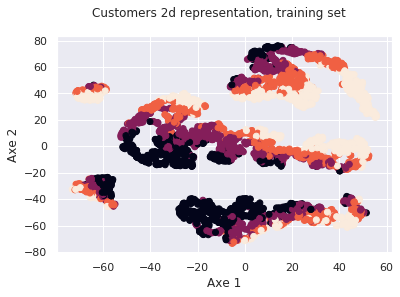

In [190]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [191]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_rfmBoughtTopValueProductsHasEverCancelled_withoutBow_final_tsne.html') 

'clusters_plot_clients_sne_rfmBoughtTopValueProductsHasEverCancelled_withoutBow_final_tsne.html'

No handles with labels found to put in legend.


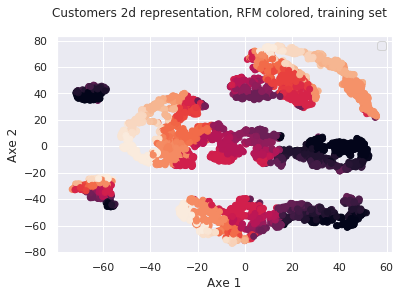

In [197]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

# Model with all bow features and RFM score (not individual feats), and TSNE, with KMeans

In [120]:
importlib.reload(sys.modules['functions'])
from functions import *

In [121]:
df_train = df_train_ori
df_test = df_test_ori

In [122]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [123]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace
Trace 2
Trace 3
Trace 4
Trace 5
Trace 6
Trace 1
Trace 2
Trace 3
Trace 4
Trace 5
Trace 6
Trace 7
Trace 8
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',

In [124]:
rfm_scores_train = df_train['RfmScore']

In [125]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [126]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [127]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [128]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [129]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [130]:
df_train

RfmScore         0         1         2
0     0.600601  0.783543  0.628913  0.878636
1     0.900901  0.727786  0.430184  0.704302
2     0.903904  0.741093  0.560714  0.462285
3     0.000000  0.648290  0.514565  0.458161
4     0.699700  0.759664  0.587738  0.564628
...        ...       ...       ...       ...
4327  0.699700  0.747399  0.632402  0.684291
4328  0.399399  0.766730  0.647952  0.548147
4329  0.399399  0.716419  0.469840  0.643490
4330  0.933934  0.727965  0.528250  0.312737
4331  0.300300  0.902739  0.582266  0.476758

[4332 rows x 4 columns]

In [131]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 4 columns):
RfmScore    4332 non-null float64
0           4332 non-null float64
1           4332 non-null float64
2           4332 non-null float64
dtypes: float64(4)
memory usage: 135.5 KB


In [132]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [133]:
X_transformed[:,1]

array([-40.201183,  46.5035  ,  46.704304, ..., -55.275963,  52.40635 ,
       -38.64302 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

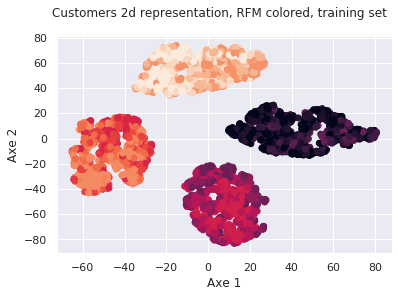

In [137]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [138]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_bowwithRFMscore_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_bowwithRFMscore_color_RFM_final_tsne.html'

# Model with 'DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore', and TSNE (BEST)

In [27]:
importlib.reload(sys.modules['functions'])
from functions import *

In [28]:
df_train = df_train_ori
df_test = df_test_ori

In [29]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [30]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'RfmScore'],
      dtype='object', length=604)
Fit Min max scaler multiple
Transform 

In [31]:
rfm_scores_train = df_train['RfmScore']

In [32]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [33]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [34]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [35]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [36]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [37]:
df_train

HasEverCancelled  RfmScore  BoughtTopValueProduct         0         1  \
0                  1.0  0.600601                    1.0  0.783543  0.628913   
1                  0.0  0.900901                    1.0  0.727786  0.430184   
2                  0.0  0.903904                    0.0  0.741093  0.560714   
3                  0.0  0.000000                    1.0  0.648290  0.514565   
4                  0.0  0.699700                    0.0  0.759664  0.587738   
...                ...       ...                    ...       ...       ...   
4327               0.0  0.699700                    0.0  0.747399  0.632402   
4328               0.0  0.399399                    0.0  0.766730  0.647952   
4329               1.0  0.399399                    1.0  0.716419  0.469840   
4330               0.0  0.933934                    1.0  0.727965  0.528250   
4331               0.0  0.300300                    0.0  0.902739  0.582266   

             2  
0     0.878636  
1     0.704302  
2     0.462285  
3     0.458161  
4     0.564628  
...        ...  
4327  0.684291  
4328  0.548147  
4329  0.643490  
4330  0.312737  
4331  0.476758  

[4332 rows x 6 columns]

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
HasEverCancelled         4332 non-null float64
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [39]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [40]:
X_transformed[:,1]

array([ 58.172222 ,  47.482548 ,   0.8590048, ..., -24.410206 ,
        73.02536  , -31.294203 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

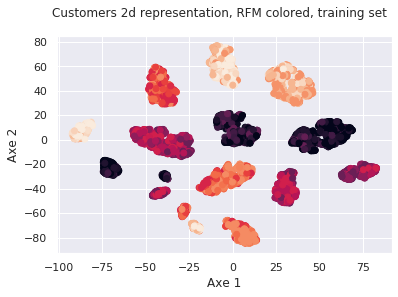

In [41]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [42]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_tsne.html'

# Model with only bow features without RfmScore, coloration with RfmScore

In [43]:
importlib.reload(sys.modules['functions'])
from functions import *

In [44]:
df_train = df_train_ori
df_test = df_test_ori

In [45]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [46]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Fit

In [31]:
#rfm_scores_train = df_train['RfmScore']  # we reuse rfm_scores_train calculated on above model

In [47]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [48]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [49]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [50]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [51]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [52]:
df_train

0         1         2
0     0.783543  0.628913  0.878636
1     0.727786  0.430184  0.704302
2     0.741093  0.560714  0.462285
3     0.648290  0.514565  0.458161
4     0.759664  0.587738  0.564628
...        ...       ...       ...
4327  0.747399  0.632402  0.684291
4328  0.766730  0.647952  0.548147
4329  0.716419  0.469840  0.643490
4330  0.727965  0.528250  0.312737
4331  0.902739  0.582266  0.476758

[4332 rows x 3 columns]

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 3 columns):
0    4332 non-null float32
1    4332 non-null float32
2    4332 non-null float32
dtypes: float32(3)
memory usage: 50.9 KB


In [54]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [55]:
X_transformed[:,1]

array([-67.1679   , -49.622208 ,  27.984085 , ..., -11.2271185,
        63.46297  ,  43.64952  ], dtype=float32)

Text(0, 0.5, 'Axe 2')

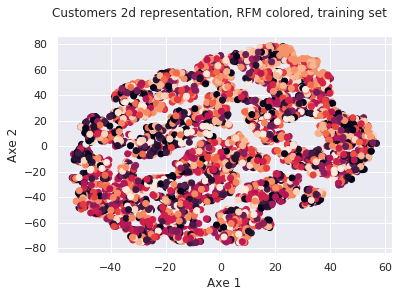

In [56]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [57]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_onlybow_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_onlybow_color_RFM_final_tsne.html'

# Model with 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore', coloration with RfmScore (INTERESTING)

In [331]:
importlib.reload(sys.modules['functions'])
from functions import *

In [332]:
df_train = df_train_ori
df_test = df_test_ori

In [333]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    #('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    #('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
    #                                                    algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [334]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'], dtype='object')
Fit Min max scaler multiple
Transform Min max scaler multiple
Trace 7 before end
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'], dtype='object')
Transform Min max scaler multiple


In [335]:
#rfm_scores_train = df_train['RfmScore']  # we reuse rfm_scores_train calculated on above model

In [336]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [337]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [338]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [339]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [340]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [341]:
df_train

BoughtTopValueProduct  HasEverCancelled  RfmScore
CustomerID                                                   
12346                         1.0               1.0  0.600601
12347                         1.0               0.0  0.900901
12348                         0.0               0.0  0.903904
12349                         1.0               0.0  0.000000
12350                         0.0               0.0  0.699700
...                           ...               ...       ...
18280                         0.0               0.0  0.699700
18281                         0.0               0.0  0.399399
18282                         1.0               1.0  0.399399
18283                         1.0               0.0  0.933934
18287                         0.0               0.0  0.300300

[4332 rows x 3 columns]

In [342]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 3 columns):
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
RfmScore                 4332 non-null float64
dtypes: float64(3)
memory usage: 135.4+ KB


In [343]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [344]:
X_transformed[:,1]

array([ -1.8730556,  58.781906 ,   7.0519733, ..., -57.905876 ,
        16.11194  ,  24.376785 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

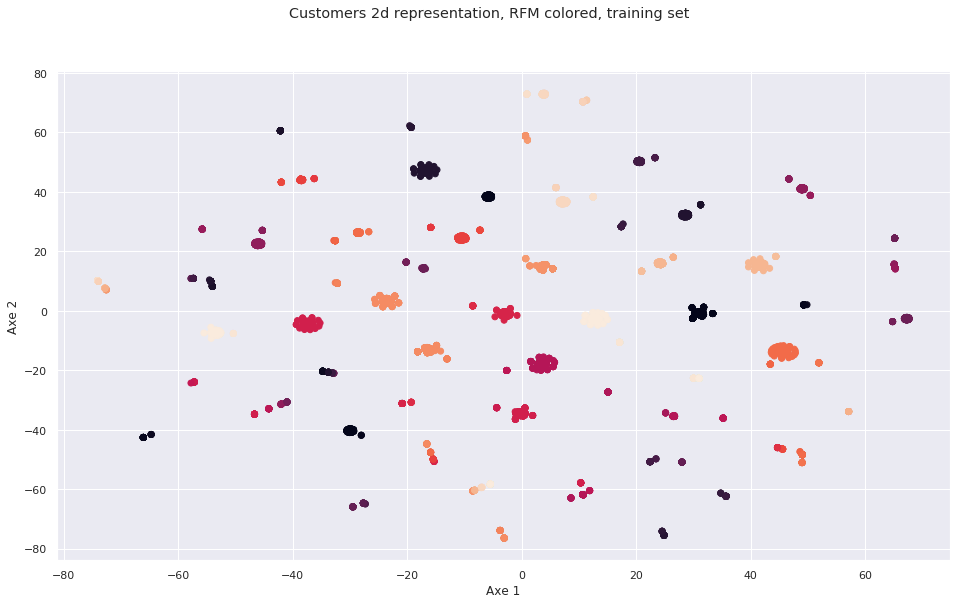

In [345]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [346]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allFeatsExceptBow_RfmScore_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_allFeatsExceptBow_RfmScore_color_RFM_final_tsne.html'

# Model with all features and RFM score (not individual RFM feats), and LLE

In [89]:
importlib.reload(sys.modules['functions'])
from functions import *

In [90]:
df_train = df_train_ori
df_test = df_test_ori

In [91]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [92]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'RfmScore'],
      dtype='object', length=604)
Fit Min max scaler multiple
Transform 

In [93]:
rfm_scores_train = df_train['RfmScore']

In [94]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [95]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [96]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [97]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [98]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [99]:
df_train

HasEverCancelled  RfmScore  BoughtTopValueProduct         0         1  \
0                  1.0  0.600601                    1.0  0.929734  0.133125   
1                  0.0  0.900901                    1.0  0.843635  0.420629   
2                  0.0  0.903904                    0.0  0.838645  0.367967   
3                  0.0  0.000000                    1.0  0.883346  0.441245   
4                  0.0  0.699700                    0.0  0.784579  0.362319   
...                ...       ...                    ...       ...       ...   
4327               0.0  0.699700                    0.0  0.172324  0.146602   
4328               0.0  0.399399                    0.0  0.928007  0.306943   
4329               1.0  0.399399                    1.0  0.770153  0.791756   
4330               0.0  0.933934                    1.0  0.859854  0.382429   
4331               0.0  0.300300                    0.0  0.860197  0.361143   

             2  
0     0.286682  
1     0.521580  
2     0.501632  
3     0.512148  
4     0.578041  
...        ...  
4327  0.630801  
4328  0.510048  
4329  0.230194  
4330  0.497818  
4331  0.518040  

[4332 rows x 6 columns]

In [100]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
HasEverCancelled         4332 non-null float64
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [101]:
'''
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_transformed = lle.fit_transform(df_train)
X_test_transformed = lle.fit_transform(df_test)
'''
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [102]:
X_transformed[:,1]

array([  9.9089575,  64.02578  , -19.40857  , ..., -22.954107 ,
        65.38041  , -60.697353 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

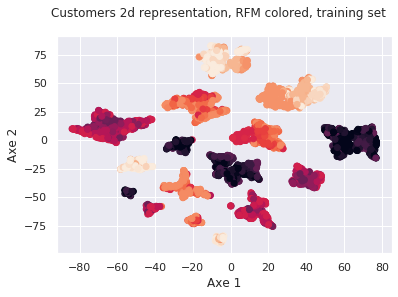

In [103]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [42]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_lle.html') 

'clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_tsne.html'

# Model with all features and RFM score (not individual RFM feats), and Isomap

In [109]:
importlib.reload(sys.modules['functions'])
from functions import *

In [110]:
df_train = df_train_ori
df_test = df_test_ori

In [111]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='ISOMAP', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [112]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'RfmScore'],
      dtype='object', length=604)
Fit Min max scaler multiple
Transform 

In [113]:
rfm_scores_train = df_train['RfmScore']

In [114]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [115]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [116]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [117]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [118]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [119]:
df_train

HasEverCancelled  RfmScore  BoughtTopValueProduct         0         1  \
0                  1.0  0.600601                    1.0  0.130221  0.503131   
1                  0.0  0.900901                    1.0  0.092100  0.488378   
2                  0.0  0.903904                    0.0  0.157459  0.577756   
3                  0.0  0.000000                    1.0  0.087152  0.600322   
4                  0.0  0.699700                    0.0  0.113605  0.537165   
...                ...       ...                    ...       ...       ...   
4327               0.0  0.699700                    0.0  0.097145  0.506489   
4328               0.0  0.399399                    0.0  0.120115  0.515198   
4329               1.0  0.399399                    1.0  0.132320  0.493318   
4330               0.0  0.933934                    1.0  0.298067  0.824862   
4331               0.0  0.300300                    0.0  0.080440  0.418782   

             2  
0     0.452280  
1     0.601755  
2     0.469424  
3     0.381877  
4     0.409637  
...        ...  
4327  0.471256  
4328  0.446693  
4329  0.601695  
4330  0.353478  
4331  0.398126  

[4332 rows x 6 columns]

In [120]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
HasEverCancelled         4332 non-null float64
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [122]:
'''
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_transformed = lle.fit_transform(df_train)
X_test_transformed = lle.fit_transform(df_test)
'''
'''
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)
'''
isomap = Isomap(n_components=2)
X_transformed = isomap.fit_transform(df_train)
X_test_transformed = isomap.fit_transform(df_test)


In [123]:
X_transformed[:,1]

array([-3.00546748e-01, -2.35021730e-03, -2.21520408e-02, ...,
       -1.17653795e+00, -9.81785940e-04, -2.20657802e-02])

Text(0, 0.5, 'Axe 2')

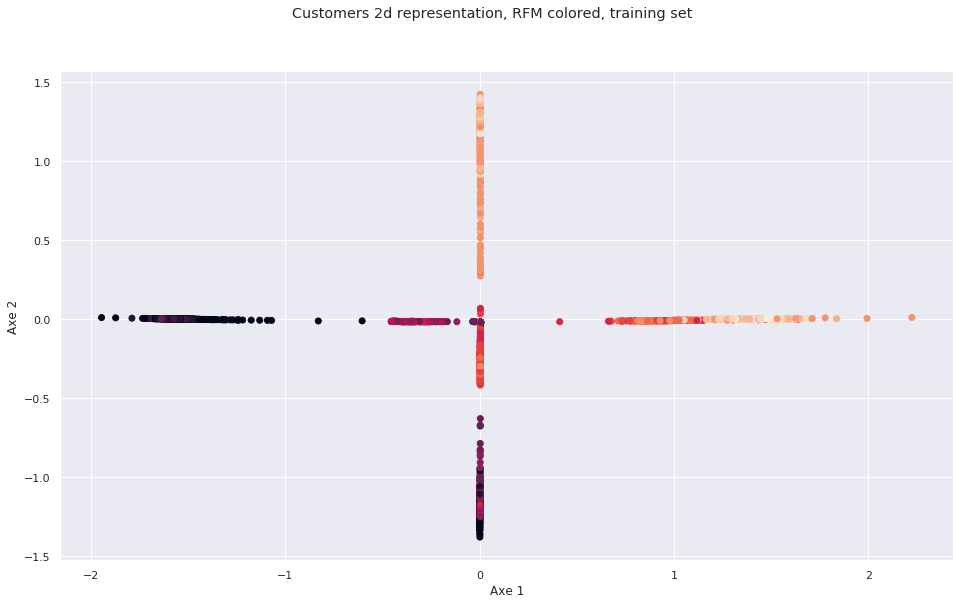

In [124]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [125]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_isomap.html') 

'clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_isomap.html'

# Model with all features and RFM score (not individual RFM feats), and NCA (BEST)

In [112]:
importlib.reload(sys.modules['functions'])
from functions import *

In [113]:
df_train = df_train_ori
df_test = df_test_ori

In [114]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [115]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'RfmScore'],
      dtype='object', length=604)
Fit Min max scaler multiple
Transform 

In [116]:
rfm_scores_train = df_train['RfmScore']

In [117]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [118]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [119]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [120]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [121]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [131]:
df_train

RfmScore  BoughtTopValueProduct  HasEverCancelled         0         1  \
0     0.600601                    1.0               1.0  0.012337  0.471256   
1     0.900901                    1.0               0.0  0.356103  0.422609   
2     0.903904                    0.0               0.0  0.103371  0.307432   
3     0.000000                    1.0               0.0  0.330665  0.428295   
4     0.699700                    0.0               0.0  0.073958  0.425344   
...        ...                    ...               ...       ...       ...   
4327  0.699700                    0.0               0.0  0.065726  0.437382   
4328  0.399399                    0.0               0.0  0.043881  0.360628   
4329  0.399399                    1.0               1.0  0.104478  0.484575   
4330  0.933934                    1.0               0.0  0.555281  0.163908   
4331  0.300300                    0.0               0.0  0.231274  0.528387   

             2  
0     0.453941  
1     0.371617  
2     0.409712  
3     0.241579  
4     0.446158  
...        ...  
4327  0.430527  
4328  0.483598  
4329  0.220637  
4330  0.491824  
4331  0.659905  

[4332 rows x 6 columns]

In [123]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [124]:
'''
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_transformed = lle.fit_transform(df_train)
X_test_transformed = lle.fit_transform(df_test)
'''

tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)


'''
isomap = Isomap(n_components=2)
X_transformed = isomap.fit_transform(df_train)
X_test_transformed = isomap.fit_transform(df_test)
'''


'\nisomap = Isomap(n_components=2)\nX_transformed = isomap.fit_transform(df_train)\nX_test_transformed = isomap.fit_transform(df_test)\n'

In [125]:
X_transformed[:,1]

array([ 21.532784 ,  61.172535 ,  -1.6540931, ..., -19.54735  ,
        52.11532  , -54.924816 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

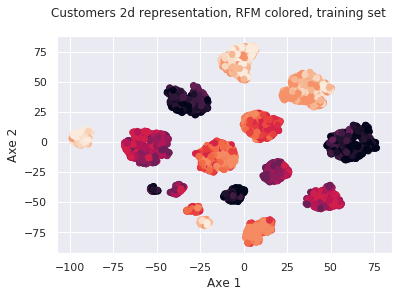

In [126]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

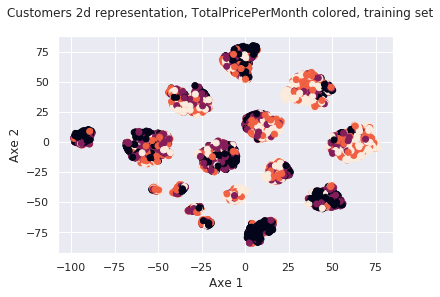

In [127]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, TotalPricePerMonth colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [130]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip('RFM: ' + rfm_scores_train.astype(str),\
                                             'BoughtTopValueProduct: ' + df_train['BoughtTopValueProduct'].astype(str),\
                                              'HasEverCancelled: '  + df_train['HasEverCancelled'].astype(str),\
                                              'Bow0: ' + df_train[0].astype(str),\
                                              'Bow1: ' + df_train[1].astype(str),\
                                              'Bow2: ' + df_train[2].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_NCA_allFeatswithRFMscore_color_RFM_final_tsnelast.html') 

'clusters_plot_clients_NCA_allFeatswithRFMscore_color_RFM_final_tsnelast.html'

# Model with all features except RFM score, and TSNE, colored by RFM

In [95]:
importlib.reload(sys.modules['functions'])
from functions import *

In [96]:
df_train = df_train_ori
df_test = df_test_ori

In [97]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [98]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'HasEverCancelled'],
      dtype='object', length=603)
Fit Dimensionality R

In [99]:
#rfm_scores_train = df_train['RfmScore'] # rfm_scores_train value has been got from code above

In [100]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [101]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [102]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [103]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [104]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [105]:
df_train

BoughtTopValueProduct  HasEverCancelled         0         1         2
0                       1.0               1.0  0.783543  0.628913  0.878636
1                       1.0               0.0  0.727786  0.430184  0.704302
2                       0.0               0.0  0.741093  0.560714  0.462285
3                       1.0               0.0  0.648290  0.514565  0.458161
4                       0.0               0.0  0.759664  0.587738  0.564628
...                     ...               ...       ...       ...       ...
4327                    0.0               0.0  0.747399  0.632402  0.684291
4328                    0.0               0.0  0.766730  0.647952  0.548147
4329                    1.0               1.0  0.716419  0.469840  0.643490
4330                    1.0               0.0  0.727965  0.528250  0.312737
4331                    0.0               0.0  0.902739  0.582266  0.476758

[4332 rows x 5 columns]

In [106]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 5 columns):
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(5)
memory usage: 169.3 KB


In [107]:
'''
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_transformed = lle.fit_transform(df_train)
X_test_transformed = lle.fit_transform(df_test)
'''

tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)


'''
isomap = Isomap(n_components=2)
X_transformed = isomap.fit_transform(df_train)
X_test_transformed = isomap.fit_transform(df_test)
'''


'\nisomap = Isomap(n_components=2)\nX_transformed = isomap.fit_transform(df_train)\nX_test_transformed = isomap.fit_transform(df_test)\n'

In [108]:
X_transformed[:,1]

array([-33.27289 ,   9.164245, -29.82518 , ..., -12.101926,  55.20925 ,
       -19.78339 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

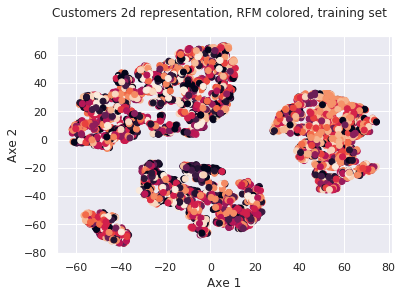

In [109]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

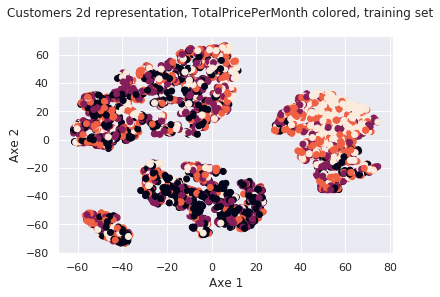

In [110]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, TotalPricePerMonth colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [111]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip('rfm: ' + rfm_scores_train.astype(str), 'BoughtTopValueProduct: ' + df_train['BoughtTopValueProduct'].astype(str),\
                                              'HasEverCancelled: '  + df_train['HasEverCancelled'].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_TSNE_allFeatswithOUTRFMscore_color_RFM_final_tsnelast.html') 

'clusters_plot_clients_TSNE_allFeatswithOUTRFMscore_color_RFM_final_tsnelast.html'

# Model with 'DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore' with NCA up to 200 then KMeans then NCA to visualize clusters   (GOOD, ONLY NCA not TSNE)

In [27]:
importlib.reload(sys.modules['functions'])
from functions import *

In [28]:
df_train = df_train_ori
df_test = df_test_ori

In [29]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [30]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'RfmScore'],
      dtype='object', length=604)
Fit Min max scaler multiple
Transform 

In [31]:
rfm_scores_train = df_train['RfmScore']
rfm_scores_test = df_test['RfmScore']

In [32]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())
unique_rfm_scores_test = np.sort(rfm_scores_test.unique())

In [33]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1

rfm_dict_colors_test = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores_test:
    rfm_dict_colors_test[unique_rfm_score] = cnt
    cnt += 1    

In [34]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])
rfm_scores_test_colors = rfm_scores_test.apply(lambda x : rfm_dict_colors_test[x])

In [35]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [36]:
rfm_scores_test_colors

0       46
1       44
2        0
3       44
4       40
        ..
3766    13
3767    44
3768     7
3769    49
3770    16
Name: RfmScore, Length: 3771, dtype: int64

In [37]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [38]:
df_train

BoughtTopValueProduct  HasEverCancelled  RfmScore         0         1  \
0                       1.0               1.0  0.600601  0.012337  0.471256   
1                       1.0               0.0  0.900901  0.356103  0.422609   
2                       0.0               0.0  0.903904  0.103371  0.307432   
3                       1.0               0.0  0.000000  0.330665  0.428295   
4                       0.0               0.0  0.699700  0.073958  0.425344   
...                     ...               ...       ...       ...       ...   
4327                    0.0               0.0  0.699700  0.065726  0.437382   
4328                    0.0               0.0  0.399399  0.043881  0.360628   
4329                    1.0               1.0  0.399399  0.104478  0.484575   
4330                    1.0               0.0  0.933934  0.555281  0.163908   
4331                    0.0               0.0  0.300300  0.231274  0.528387   

             2  
0     0.453941  
1     0.371617  
2     0.409712  
3     0.241579  
4     0.446158  
...        ...  
4327  0.430527  
4328  0.483598  
4329  0.220637  
4330  0.491824  
4331  0.659905  

[4332 rows x 6 columns]

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
RfmScore                 4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [40]:
'''
df_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))
df_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))
'''

"\ndf_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))\ndf_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))\n"

In [41]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [42]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [43]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [44]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [45]:
# Model corresponding to max silhouette score. We add +1 because "for model in kmeans_per_k[1:] above has suppressed one indice"
# kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_

In [46]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['RfmScore'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['RfmScore'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

/home/francois/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning:

invalid value encountered in true_divide



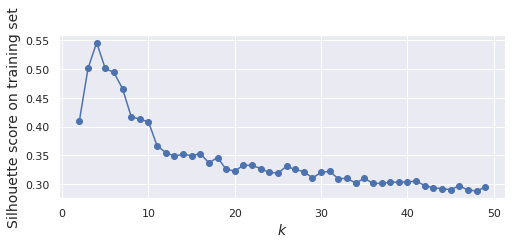

In [47]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

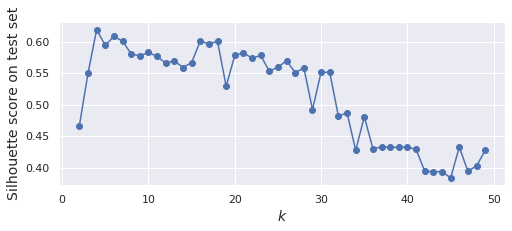

In [48]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [49]:
print('Entropy before clustering :')
entropy(df_train['RfmScore'])

Entropy before clustering :


8.067719138182103

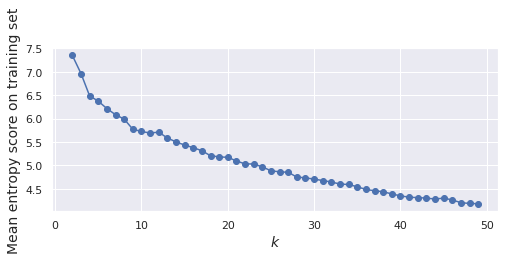

In [50]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

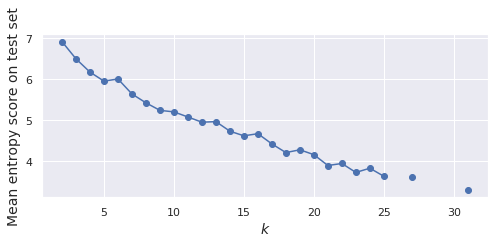

In [51]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## Reduce and visualize

In [414]:
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
X_transformed = nca.fit_transform(df_train, pd.cut(df_train['RfmScore'], bins=range(1,10), right=True).astype(str).tolist())
X_test_transformed = nca.transform(df_test)

Text(0, 0.5, 'Axe 2')

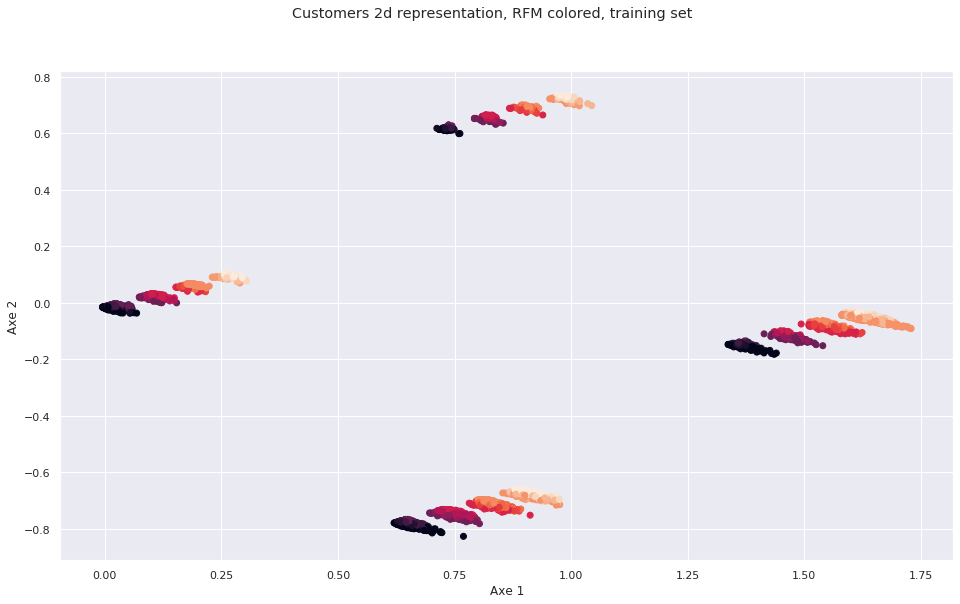

In [415]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

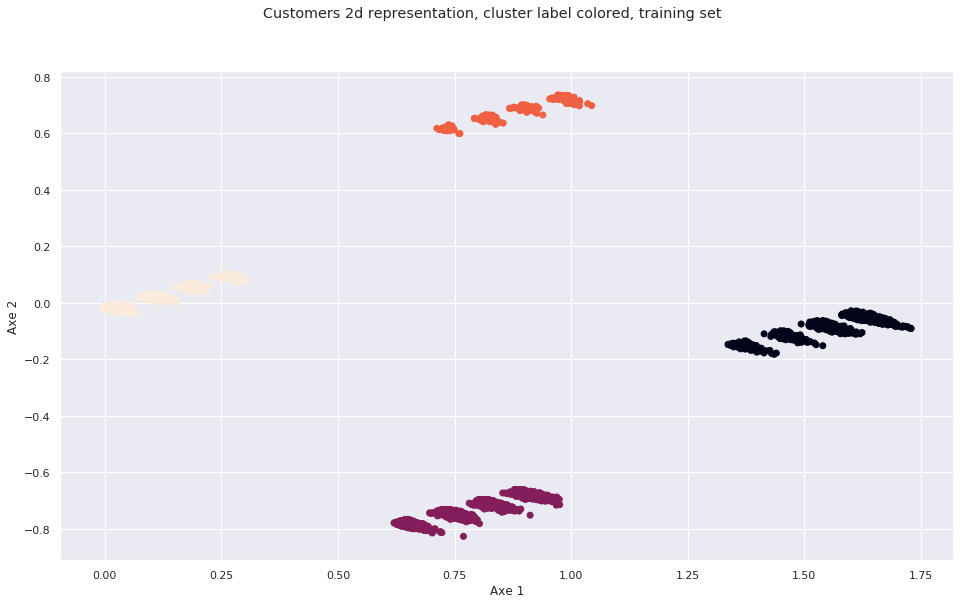

In [416]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, cluster label colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [324]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_transformed)
                for k in range(1, 50)]

In [325]:
labels_test_per_k = [model.predict(X_test_transformed) for model in kmeans_per_k[1:]]

In [326]:
silhouette_scores = [silhouette_score(X_transformed, model.labels_)
                     for model in kmeans_per_k[1:]]

In [327]:
silhouette_scores_test = [silhouette_score(X_test_transformed, labels_test) for labels_test in labels_test_per_k]

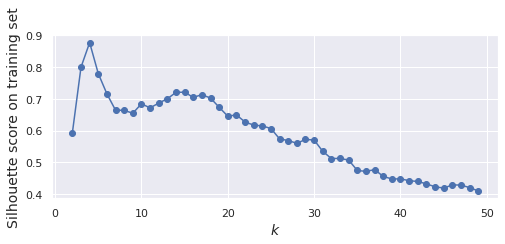

In [329]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

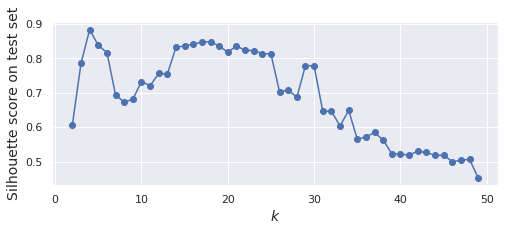

In [330]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [309]:
print('Entropy before clustering :')
entropy(df_train['RfmScore'])

Entropy before clustering :


8.067719138182103

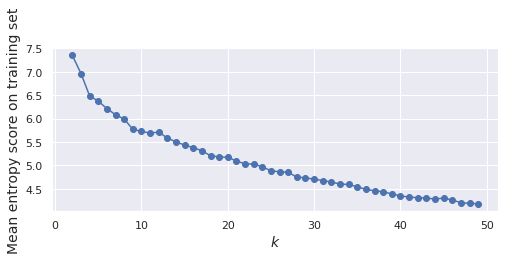

In [310]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

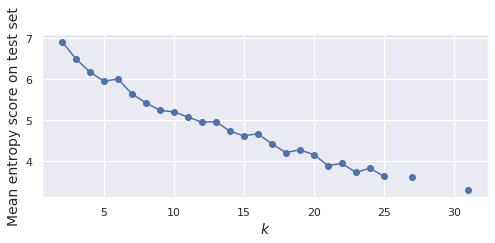

In [311]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with 'TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled' with NCA up to 200 then KMeans then TSNE to visualize clusters

In [351]:
importlib.reload(sys.modules['functions'])
from functions import *

In [352]:
df_train = df_train_ori
df_test = df_test_ori

In [353]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth'])),
    #('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
    #                                                    algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    #('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [354]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'HasEverCancelled', 'Recency',
       'TotalPricePerMonth', 'TotalQuantityPerMonth'],
      dtype='object')
Fit Min max scaler multiple
Transform Min max scaler multiple
Transform data
Trace 7 before end
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'HasEverCancelled', 'Recency',
       'TotalPricePerMonth', 'TotalQuantityPerMonth'],
      dtype='object')
Transform Min max scaler multiple


In [355]:
#rfm_scores_train = df_train['RfmScore']  # Got from code above
#rfm_scores_test = df_test['RfmScore']

In [356]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())
unique_rfm_scores_test = np.sort(rfm_scores_test.unique())

In [357]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1

rfm_dict_colors_test = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores_test:
    rfm_dict_colors_test[unique_rfm_score] = cnt
    cnt += 1    

In [358]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])
rfm_scores_test_colors = rfm_scores_test.apply(lambda x : rfm_dict_colors_test[x])

In [359]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [360]:
rfm_scores_test_colors

0       46
1       44
2        0
3       44
4       40
        ..
3766    13
3767    44
3768     7
3769    49
3770    16
Name: RfmScore, Length: 3771, dtype: int64

In [361]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [362]:
df_train

BoughtTopValueProduct  HasEverCancelled   Recency  \
CustomerID                                                      
12346                           1                 1  0.859762   
12347                           1                 0  0.981702   
12348                           0                 0  0.954933   
12349                           1                 0  0.000000   
12350                           0                 0  0.815269   
...                           ...               ...       ...   
18280                           0                 0  0.719735   
18281                           0                 0  0.436604   
18282                           1                 1  0.278725   
18283                           1                 0  0.894261   
18287                           0                 0  0.497902   

            TotalPricePerMonth  TotalQuantityPerMonth  
CustomerID                                             
12346                 0.289049               0.444426  
12347                 0.013128               0.011732  
12348                 0.004822               0.012556  
12349                 0.051691               0.037543  
12350                 0.001098               0.001151  
...                        ...                    ...  
18280                 0.000689               0.000290  
18281                 0.000546               0.000579  
18282                 0.001672               0.001401  
18283                 0.006640               0.007079  
18287                 0.010199               0.013762  

[4332 rows x 5 columns]

In [363]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 5 columns):
BoughtTopValueProduct    4332 non-null int64
HasEverCancelled         4332 non-null int64
Recency                  4332 non-null float64
TotalPricePerMonth       4332 non-null float64
TotalQuantityPerMonth    4332 non-null float64
dtypes: float64(3), int64(2)
memory usage: 203.1+ KB


In [364]:
'''
df_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))
df_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))
'''

"\ndf_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))\ndf_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))\n"

In [365]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [366]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [367]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [368]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

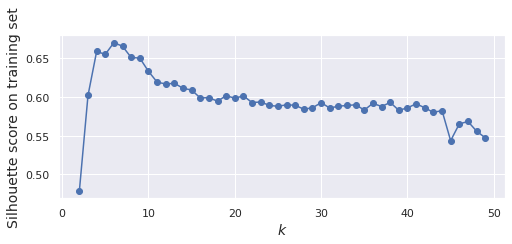

In [370]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

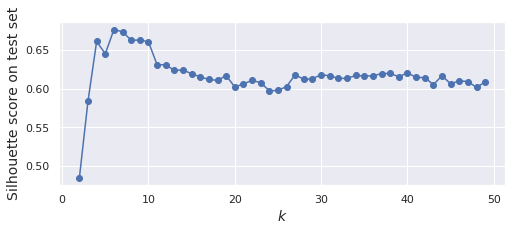

In [371]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## Reduce and visualize

In [373]:
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
X_transformed = nca.fit_transform(df_train, pd.cut(rfm_scores_train, bins=range(1,10), right=True).astype(str).tolist())
X_test_transformed = nca.transform(df_test)

Text(0, 0.5, 'Axe 2')

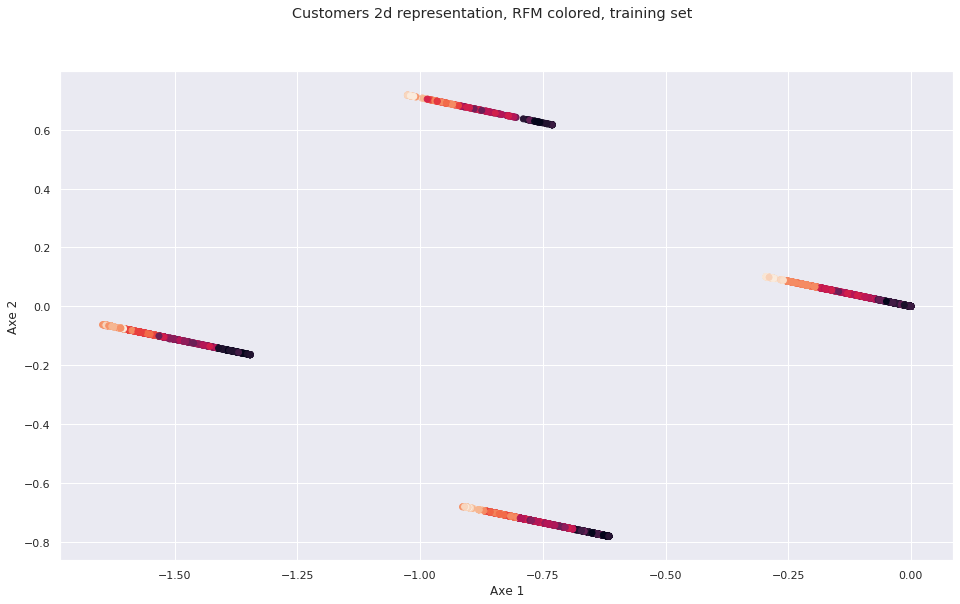

In [374]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [375]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_transformed)
                for k in range(1, 50)]

In [376]:
labels_test_per_k = [model.predict(X_test_transformed) for model in kmeans_per_k[1:]]

In [377]:
silhouette_scores = [silhouette_score(X_transformed, model.labels_)
                     for model in kmeans_per_k[1:]]

In [378]:
silhouette_scores_test = [silhouette_score(X_test_transformed, labels_test) for labels_test in labels_test_per_k]

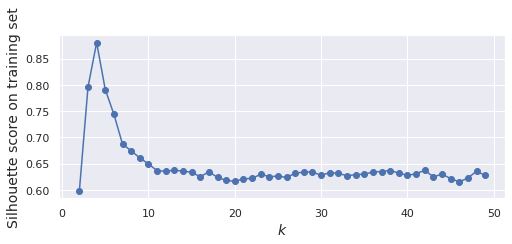

In [379]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

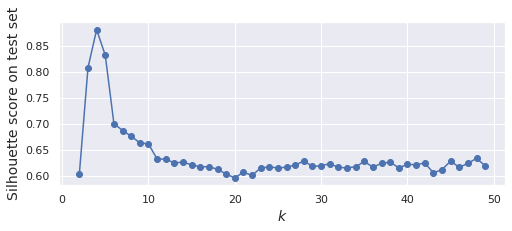

In [380]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency' then KMeans then 3D visualisation

In [429]:
importlib.reload(sys.modules['functions'])
from functions import *

In [430]:
df_train = df_train_ori
df_test = df_test_ori

In [431]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    #('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    #('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
    #                                                    algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [432]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['Recency', 'TotalPricePerMonth', 'TotalQuantityPerMonth'], dtype='object')
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Trace 7 before end
Transform FeaturesSelector
Features selected (in order): Index(['Recency', 'TotalPricePerMonth', 'TotalQuantityPerMonth'], dtype='object')
Transform log scaler scaler multiple
Transform Min max scaler multiple


In [433]:
#rfm_scores_train = df_train['RfmScore']  # Got from above
#rfm_scores_test = df_test['RfmScore']

In [434]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())
unique_rfm_scores_test = np.sort(rfm_scores_test.unique())

In [435]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1

rfm_dict_colors_test = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores_test:
    rfm_dict_colors_test[unique_rfm_score] = cnt
    cnt += 1    

In [436]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])
rfm_scores_test_colors = rfm_scores_test.apply(lambda x : rfm_dict_colors_test[x])

In [437]:
rfm_scores_train_colors

0       31
1       45
2       46
3        0
4       44
        ..
4327    44
4328    30
4329    30
4330    50
4331    16
Name: RfmScore, Length: 4332, dtype: int64

In [438]:
rfm_scores_test_colors

0       46
1       44
2        0
3       44
4       40
        ..
3766    13
3767    44
3768     7
3769    49
3770    16
Name: RfmScore, Length: 3771, dtype: int64

In [439]:
rfm_scores_train

0       0.600601
1       0.900901
2       0.903904
3       0.000000
4       0.699700
          ...   
4327    0.699700
4328    0.399399
4329    0.399399
4330    0.933934
4331    0.300300
Name: RfmScore, Length: 4332, dtype: float64

In [440]:
df_train

Recency  TotalPricePerMonth  TotalQuantityPerMonth
CustomerID                                                     
12346       0.859762            0.877446               0.915344
12347       0.981702            0.572415               0.536506
12348       0.954933            0.474029               0.543549
12349       0.000000            0.707529               0.657517
12350       0.815269            0.330609               0.299590
...              ...                 ...                    ...
18280       0.719735            0.286691               0.171885
18281       0.436604            0.265155               0.233494
18282       0.278725            0.370964               0.319077
18283       0.894261            0.505393               0.484163
18287       0.497902            0.547572               0.553078

[4332 rows x 3 columns]

In [441]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 3 columns):
Recency                  4332 non-null float64
TotalPricePerMonth       4332 non-null float64
TotalQuantityPerMonth    4332 non-null float64
dtypes: float64(3)
memory usage: 135.4+ KB


In [442]:
'''
df_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))
df_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))
'''

"\ndf_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))\ndf_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))\n"

In [443]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [444]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [445]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [446]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [447]:
# Model corresponding to max silhouette score. We add +1 because "for model in kmeans_per_k[1:] above has suppressed one indice"
# kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_

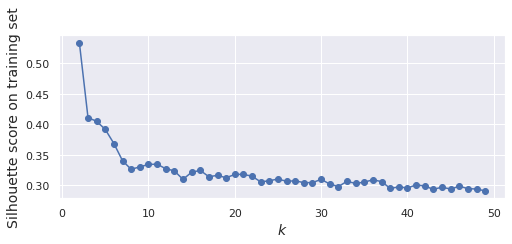

In [449]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

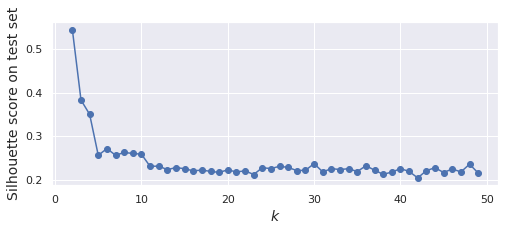

In [450]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## Visualize

In [452]:
df_train

Recency  TotalPricePerMonth  TotalQuantityPerMonth
CustomerID                                                     
12346       0.859762            0.877446               0.915344
12347       0.981702            0.572415               0.536506
12348       0.954933            0.474029               0.543549
12349       0.000000            0.707529               0.657517
12350       0.815269            0.330609               0.299590
...              ...                 ...                    ...
18280       0.719735            0.286691               0.171885
18281       0.436604            0.265155               0.233494
18282       0.278725            0.370964               0.319077
18283       0.894261            0.505393               0.484163
18287       0.497902            0.547572               0.553078

[4332 rows x 3 columns]

In [454]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.loc[:,'Recency'], y = df_train.loc[:,'TotalPricePerMonth'], z = df_train.loc[:,'TotalQuantityPerMonth'],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip(
                                              '0: ' + df_train['Recency'].astype(str),\
                                              '1: ' + df_train['TotalPricePerMonth'].astype(str),\
                                              '2: ' + df_train['TotalQuantityPerMonth'].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_NCA_3RFMfeats_color_RFM.html') 

'clusters_plot_clients_NCA_3RFMfeats_color_RFM.html'

In [456]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.loc[:,'Recency'], y = df_train.loc[:,'TotalPricePerMonth'], z = df_train.loc[:,'TotalQuantityPerMonth'],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip(
                                              '0: ' + df_train['Recency'].astype(str),\
                                              '1: ' + df_train['TotalPricePerMonth'].astype(str),\
                                              '2: ' + df_train['TotalQuantityPerMonth'].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_NCA_3RFMfeats_color_clusterlabels.html') 

'clusters_plot_clients_NCA_3RFMfeats_color_clusterlabels.html'

Text(0, 0.5, 'Axe 2')

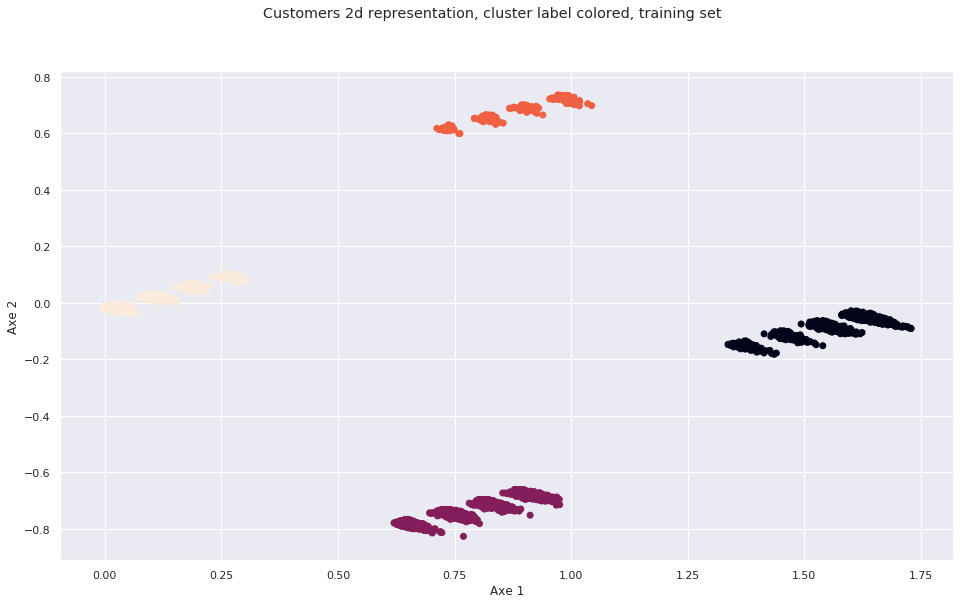

In [416]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, cluster label colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [324]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_transformed)
                for k in range(1, 50)]

In [325]:
labels_test_per_k = [model.predict(X_test_transformed) for model in kmeans_per_k[1:]]

In [326]:
silhouette_scores = [silhouette_score(X_transformed, model.labels_)
                     for model in kmeans_per_k[1:]]

In [327]:
silhouette_scores_test = [silhouette_score(X_test_transformed, labels_test) for labels_test in labels_test_per_k]

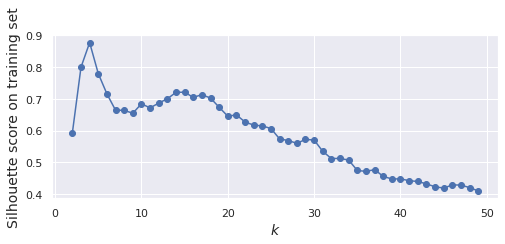

In [329]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

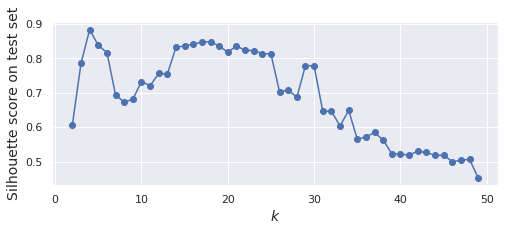

In [330]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [309]:
print('Entropy before clustering :')
entropy(df_train['RfmScore'])

Entropy before clustering :


8.067719138182103

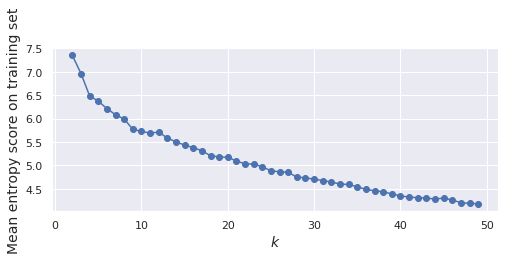

In [310]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Correlations

In [70]:
importlib.reload(sys.modules['functions'])
from functions import *

In [71]:
df_train = df_train_ori
df_test = df_test_ori

In [72]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'RfmScore', 'BoughtTopValueProduct', 'HasEverCancelled'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    #('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [73]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Trace 7 before end
Fit FeaturesSelector
Transform FeaturesSelector
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'HasEverCancelled', 'Recency', 'RfmScore',
       'TotalPricePerMonth', 'TotalQuantityPerMonth'],
      dtype='object', length=607)
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler 

In [75]:
corr_matrix = df_train.corr()

In [76]:
corr_matrix

RfmScore   Recency  BoughtTopValueProduct  \
RfmScore               1.000000  0.965411               0.136532   
Recency                0.965411  1.000000               0.171966   
BoughtTopValueProduct  0.136532  0.171966               1.000000   
HasEverCancelled       0.230099  0.271188               0.207875   
TotalQuantityPerMonth -0.269206 -0.220202               0.247532   
TotalPricePerMonth    -0.250905 -0.206441               0.321118   
0                      0.251430  0.303252               0.456582   
1                      0.068831  0.061220               0.102785   
2                     -0.126814 -0.146479              -0.095258   

                       HasEverCancelled  TotalQuantityPerMonth  \
RfmScore                       0.230099              -0.269206   
Recency                        0.271188              -0.220202   
BoughtTopValueProduct          0.207875               0.247532   
HasEverCancelled               1.000000               0.275306   
TotalQuantityPerMonth          0.275306               1.000000   
TotalPricePerMonth             0.310096               0.924135   
0                              0.344052               0.521432   
1                              0.033753              -0.142819   
2                             -0.140435               0.056631   

                       TotalPricePerMonth             0             1  \
RfmScore                        -0.250905  2.514304e-01  6.883104e-02   
Recency                         -0.206441  3.032520e-01  6.121952e-02   
BoughtTopValueProduct            0.321118  4.565820e-01  1.027854e-01   
HasEverCancelled                 0.310096  3.440522e-01  3.375329e-02   
TotalQuantityPerMonth            0.924135  5.214324e-01 -1.428187e-01   
TotalPricePerMonth               1.000000  5.372127e-01 -5.949333e-02   
0                                0.537213  1.000000e+00  7.738857e-15   
1                               -0.059493  7.738857e-15  1.000000e+00   
2                               -0.029178  1.481107e-15  2.622739e-09   

                                  2  
RfmScore              -1.268135e-01  
Recency               -1.464791e-01  
BoughtTopValueProduct -9.525832e-02  
HasEverCancelled      -1.404353e-01  
TotalQuantityPerMonth  5.663114e-02  
TotalPricePerMonth    -2.917771e-02  
0                      1.481107e-15  
1                      2.622739e-09  
2                      1.000000e+00

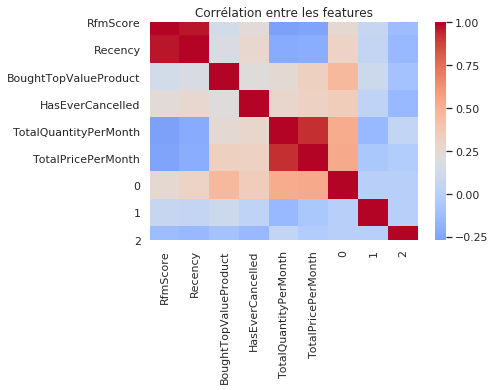

In [77]:
plt.title('Corrélation entre les features')
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns, cmap='coolwarm' ,center=0.20)

In [84]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("BMI ~ 0 + 1 + 2", data=df_train).fit()
#print model.params
#print model.summary()

PatsyError: numbers besides '0' and '1' are only allowed with **
    BMI ~ 0 + 1 + 2
                  ^

# Annex

## Display some data

In [26]:
df_nocancel = df[df['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [27]:
df_nocancel.head(2)

index InvoiceNo StockCode                         Description  Quantity  \
0      0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1      1    536365     71053                 WHITE METAL LANTERN         6   

           InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  \
0  2010-12-01 08:26:00       2.55      17850  United Kingdom       15.30   
1  2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   

                DescriptionNormalized         InvoiceMonth  
0  WHITE HANGING HEART T-LIGHT HOLDER  2010-12-01 00:00:00  
1                 WHITE METAL LANTERN  2010-12-01 00:00:00

In [28]:
df_nocancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391328 entries, 0 to 391327
Data columns (total 12 columns):
index                    391328 non-null int64
InvoiceNo                391328 non-null object
StockCode                391328 non-null object
Description              391328 non-null object
Quantity                 391328 non-null int64
InvoiceDate              391328 non-null object
UnitPrice                391328 non-null float64
CustomerID               391328 non-null object
Country                  391328 non-null object
TotalPrice               391328 non-null float64
DescriptionNormalized    391328 non-null object
InvoiceMonth             391328 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 35.8+ MB


In [29]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"], format="%Y-%m-%d ")

In [30]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"])

In [31]:
np.maximum((pd.to_datetime('2011-12-09 12:50:00') - invoice_dates) / (np.timedelta64(1, "M")), 1)[123456]

6.997862150945377

In [32]:
df_gbcustom_firstorder = df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()

In [33]:
df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate']

CustomerID
12346    2011-01-18 10:01:00
12347    2010-12-07 14:57:00
12348    2010-12-16 19:09:00
12349    2011-11-21 09:51:00
12350    2011-02-02 16:01:00
                ...         
18280    2011-03-07 09:52:00
18281    2011-06-12 10:53:00
18282    2011-08-05 13:35:00
18283    2011-01-06 14:14:00
18287    2011-05-22 10:39:00
Name: InvoiceDate, Length: 4336, dtype: object

In [34]:
(\
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
)\
  / (np.timedelta64(1, "M"))

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     0.595472
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4336, dtype: float64

In [35]:
# Number of months between first order date and last date of the dataset
series_gbclient_nbmonths = np.maximum(\
(
   (
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
   )\
    / (np.timedelta64(1, "M"))
), 1)

In [36]:
df_nocancel[['CustomerID', ]]

CustomerID
0           17850
1           17850
2           17850
3           17850
4           17850
...           ...
391323      12680
391324      12680
391325      12680
391326      12680
391327      12680

[391328 rows x 1 columns]

In [37]:
df_gbcustom_firstorder

InvoiceDate
CustomerID                     
12346       2011-01-18 10:01:00
12347       2010-12-07 14:57:00
12348       2010-12-16 19:09:00
12349       2011-11-21 09:51:00
12350       2011-02-02 16:01:00
...                         ...
18280       2011-03-07 09:52:00
18281       2011-06-12 10:53:00
18282       2011-08-05 13:35:00
18283       2011-01-06 14:14:00
18287       2011-05-22 10:39:00

[4336 rows x 1 columns]

In [38]:
df_nocancel[df_nocancel['CustomerID'] == '18281'].sort_values(by='InvoiceDate', ascending=True)

index InvoiceNo StockCode                   Description  Quantity  \
153118  156809    556464     22037           ROBOT BIRTHDAY CARD        12   
153119  156810    556464     22716            CARD CIRCUS PARADE        12   
153120  156811    556464     22028  PENNY FARTHING BIRTHDAY CARD        12   
153121  156812    556464     23007        SPACEBOY BABY GIFT SET         1   
153122  156813    556464     23008      DOLLY GIRL BABY GIFT SET         1   
153123  156814    556464     23209      LUNCH BAG DOILEY PATTERN        10   
153124  156815    556464     22467             GUMBALL COAT RACK         6   

                InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  \
153118  2011-06-12 10:53:00       0.42      18281  United Kingdom        5.04   
153119  2011-06-12 10:53:00       0.42      18281  United Kingdom        5.04   
153120  2011-06-12 10:53:00       0.42      18281  United Kingdom        5.04   
153121  2011-06-12 10:53:00      16.95      18281  United Kingdom       16.95   
153122  2011-06-12 10:53:00      16.95      18281  United Kingdom       16.95   
153123  2011-06-12 10:53:00       1.65      18281  United Kingdom       16.50   
153124  2011-06-12 10:53:00       2.55      18281  United Kingdom       15.30   

               DescriptionNormalized         InvoiceMonth  
153118           ROBOT BIRTHDAY CARD  2011-06-01 00:00:00  
153119            CARD CIRCUS PARADE  2011-06-01 00:00:00  
153120  PENNY FARTHING BIRTHDAY CARD  2011-06-01 00:00:00  
153121        SPACEBOY BABY GIFT SET  2011-06-01 00:00:00  
153122      DOLLY GIRL BABY GIFT SET  2011-06-01 00:00:00  
153123       LUNCH BAG VINTAGE DOILY  2011-06-01 00:00:00  
153124             GUMBALL COAT RACK  2011-06-01 00:00:00

In [39]:
invoice_dates[2000:2010]

2000   2010-12-02 09:43:00
2001   2010-12-02 09:43:00
2002   2010-12-02 09:43:00
2003   2010-12-02 09:43:00
2004   2010-12-02 09:43:00
2005   2010-12-02 09:43:00
2006   2010-12-02 09:43:00
2007   2010-12-02 09:43:00
2008   2010-12-02 09:44:00
2009   2010-12-02 09:44:00
Name: InvoiceDate, dtype: datetime64[ns]

In [40]:
df_nocancel.loc[2000:2010,'InvoiceDate']

2000    2010-12-02 09:43:00
2001    2010-12-02 09:43:00
2002    2010-12-02 09:43:00
2003    2010-12-02 09:43:00
2004    2010-12-02 09:43:00
2005    2010-12-02 09:43:00
2006    2010-12-02 09:43:00
2007    2010-12-02 09:43:00
2008    2010-12-02 09:44:00
2009    2010-12-02 09:44:00
2010    2010-12-02 09:44:00
Name: InvoiceDate, dtype: object

In [41]:
df_nocancel.loc[100000:100010,'InvoiceMonth']

100000    2011-04-01 00:00:00
100001    2011-04-01 00:00:00
100002    2011-04-01 00:00:00
100003    2011-04-01 00:00:00
100004    2011-04-01 00:00:00
100005    2011-04-01 00:00:00
100006    2011-04-01 00:00:00
100007    2011-04-01 00:00:00
100008    2011-04-01 00:00:00
100009    2011-04-01 00:00:00
100010    2011-04-01 00:00:00
Name: InvoiceMonth, dtype: object

In [42]:
df[df['InvoiceNo'].str.startswith('C') == True]['CustomerID'].unique()

array(['14527', '15311', '17548', ..., '12985', '15951', '16446'],
      dtype=object)

In [43]:
# Product codes that contain chars instead of numbers
df[df['StockCode'].str.isalpha()]['StockCode'].unique()

array(['D'], dtype=object)

# For debug / test (clean code is in functions.py)

In [44]:
df_train = df_train_ori
df_test = df_test_ori

In [45]:
df_train.head(6)

index InvoiceNo StockCode                         Description  Quantity  \
0   11503    537781     21377  SMALL CAMPHOR WOOD FIELD  MUSHROOM         1   
1   40887    541855     21947           SET OF 6 HEART CHOPSTICKS         1   
2  103799    549646    85031A      ROMANTIC IMAGES SCRAP BOOK SET         6   
3  372911    578856     23535             WALL ART BICYCLE SAFETY         4   
4  297823    571747     23396   LE JARDIN BOTANIQUE CUSHION COVER         4   
5  359556    577535     21098               CHRISTMAS TOILET ROLL         3   

           InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  \
0  2010-12-08 12:46:00       1.65      17341  United Kingdom        1.65   
1  2011-01-23 14:59:00       1.25      13742  United Kingdom        1.25   
2  2011-04-11 11:51:00       1.25      12982  United Kingdom        7.50   
3  2011-11-27 11:18:00       5.95      17769  United Kingdom       23.80   
4  2011-10-19 10:59:00       3.75      13849  United Kingdom       15.00   
5  2011-11-20 14:07:00       1.25      14071  United Kingdom        3.75   

                DescriptionNormalized         InvoiceMonth  
0  SMALL CAMPHOR WOOD FIELD  MUSHROOM  2010-12-01 00:00:00  
1           SET OF 6 HEART CHOPSTICKS  2011-01-01 00:00:00  
2      ROMANTIC IMAGES SCRAP BOOK SET  2011-04-01 00:00:00  
3             WALL ART BICYCLE SAFETY  2011-11-01 00:00:00  
4   LE JARDIN BOTANIQUE CUSHION COVER  2011-10-01 00:00:00  
5               CHRISTMAS TOILET ROLL  2011-11-01 00:00:00

In [46]:
df_train

index InvoiceNo StockCode                         Description  \
0        11503    537781     21377  SMALL CAMPHOR WOOD FIELD  MUSHROOM   
1        40887    541855     21947           SET OF 6 HEART CHOPSTICKS   
2       103799    549646    85031A      ROMANTIC IMAGES SCRAP BOOK SET   
3       372911    578856     23535             WALL ART BICYCLE SAFETY   
4       297823    571747     23396   LE JARDIN BOTANIQUE CUSHION COVER   
...        ...       ...       ...                                 ...   
359915  128343    552843     22692         DOORMAT WELCOME TO OUR HOME   
359916  272049    569401     23356               LOVE HOT WATER BOTTLE   
359917  225276    564554     23280   FOLDING BUTTERFLY MIRROR HOT PINK   
359918  302898    572274     22423            REGENCY CAKESTAND 3 TIER   
359919  153432    555944     23165       LARGE CERAMIC TOP STORAGE JAR   

        Quantity          InvoiceDate  UnitPrice CustomerID         Country  \
0              1  2010-12-08 12:46:00       1.65      17341  United Kingdom   
1              1  2011-01-23 14:59:00       1.25      13742  United Kingdom   
2              6  2011-04-11 11:51:00       1.25      12982  United Kingdom   
3              4  2011-11-27 11:18:00       5.95      17769  United Kingdom   
4              4  2011-10-19 10:59:00       3.75      13849  United Kingdom   
...          ...                  ...        ...        ...             ...   
359915         1  2011-05-11 14:37:00       7.95      14649  United Kingdom   
359916         3  2011-10-04 08:56:00       5.95      15111  United Kingdom   
359917         1  2011-08-25 19:39:00       0.83      17189  United Kingdom   
359918        16  2011-10-21 16:48:00      10.95      14031  United Kingdom   
359919        12  2011-06-08 10:36:00       1.65      16955  United Kingdom   

        TotalPrice               DescriptionNormalized         InvoiceMonth  
0             1.65  SMALL CAMPHOR WOOD FIELD  MUSHROOM  2010-12-01 00:00:00  
1             1.25           SET OF 6 HEART CHOPSTICKS  2011-01-01 00:00:00  
2             7.50      ROMANTIC IMAGES SCRAP BOOK SET  2011-04-01 00:00:00  
3            23.80             WALL ART BICYCLE SAFETY  2011-11-01 00:00:00  
4            15.00   LE JARDIN BOTANIQUE CUSHION COVER  2011-10-01 00:00:00  
...            ...                                 ...                  ...  
359915        7.95         DOORMAT WELCOME TO OUR HOME  2011-05-01 00:00:00  
359916       17.85               LOVE HOT WATER BOTTLE  2011-10-01 00:00:00  
359917        0.83   FOLDING BUTTERFLY MIRROR HOT PINK  2011-08-01 00:00:00  
359918      175.20            REGENCY CAKESTAND 3 TIER  2011-10-01 00:00:00  
359919       19.80       LARGE CERAMIC TOP STORAGE JAR  2011-06-01 00:00:00  

[359920 rows x 12 columns]

In [49]:
df_train_nocancel = df_train[df_train['InvoiceNo'].str.startswith('C') == False]
df_train_nocancel.reset_index(inplace=True)

In [37]:
feat_list = ['CustomerID', 'TotalPrice']
feat_list_bow = [col for col in df_train_nocancel if col.startswith('DescriptionNormalized_')]
feat_list.extend(feat_list_bow)

In [38]:
feat_list

['CustomerID', 'TotalPrice']

In [39]:
df_train_gbcust_nocancel = df_train_nocancel[feat_list].groupby('CustomerID').sum()

In [51]:
df_train_gbcust_nocancel[feat_list_bow] = df_train_gbcust_nocancel[feat_list_bow].clip(upper=1)

In [52]:
df_train_gbcust_nocancel

TotalPrice
CustomerID            
12346         77183.60
12347          3956.22
12348          1416.84
12349          1292.19
12350           279.40
...                ...
18280           156.90
18281            80.82
18282           173.01
18283          1837.51
18287          1684.52

[4332 rows x 1 columns]

In [40]:
# Number of months between first order date and last date of the dataset
series_train_gbclient_nbmonths = np.maximum(\
(
   (
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_train_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
   )\
    / (np.timedelta64(1, "M"))
), 1)

In [41]:
series_train_gbclient_nbmonths

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     1.000000
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4332, dtype: float64

In [42]:
df_train_gbcust_nocancel['TotalPrice'] 

CustomerID
12346    77183.60
12347     3956.22
12348     1416.84
12349     1292.19
12350      279.40
           ...   
18280      156.90
18281       80.82
18282      173.01
18283     1837.51
18287     1684.52
Name: TotalPrice, Length: 4332, dtype: float64

In [43]:
df_train_gbcust_nocancel['TotalPrice'] = df_train_gbcust_nocancel['TotalPrice'] / series_train_gbclient_nbmonths

In [44]:
df_train_gbcust_nocancel

TotalPrice
CustomerID             
12346       7225.783259
12347        328.185062
12348        120.547233
12349       1292.190000
12350         27.444203
...                 ...
18280         17.232547
18281         13.659991
18282         41.803096
18283        165.987373
18287        254.966815

[4332 rows x 1 columns]

In [46]:
df_train_gbcust_nocancel['Recency'] = series_train_gbclient_nbmonths

In [47]:
df_train_gbcust_nocancel

TotalPrice    Recency
CustomerID                        
12346       7225.783259  10.681693
12347        328.185062  12.054845
12348        120.547233  11.753401
12349       1292.190000   1.000000
12350         27.444203  10.180656
...                 ...        ...
18280         17.232547   9.104864
18281         13.659991   5.916549
18282         41.803096   4.138689
18283        165.987373  11.070179
18287        254.966815   6.606821

[4332 rows x 2 columns]

In [65]:
df_train_nocancel[['CustomerID', 'Quantity']].groupby('CustomerID').sum()['Quantity']

CustomerID
12346    74215
12347     2212
12348     2308
12349      587
12350      184
         ...  
18280       42
18281       54
18282       91
18283     1226
18287     1422
Name: Quantity, Length: 4332, dtype: int64

In [62]:
series_train_gbclient_nbmonths

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     1.000000
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4332, dtype: float64

In [66]:
df_train_nocancel[['CustomerID', 'Quantity']].groupby('CustomerID').sum()['Quantity'] / series_train_gbclient_nbmonths

CustomerID
12346    6947.868519
12347     183.494689
12348     196.368689
12349     587.000000
12350      18.073491
            ...     
18280       4.612919
18281       9.126943
18282      21.987641
18283     110.747979
18287     215.232120
Length: 4332, dtype: float64

In [53]:
df_train_nocancel[['CustomerID', 'Quantity']].groupby('CustomerID').sum() / series_train_gbclient_nbmonths

12346  12347  12348  12349  12350  12352  12353  12354  12355  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            12356  12357  12358  12359  12360  12361  12362  12363  12364  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            12365  12367  12370  12371  12372  12373  12374  12375  12377  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            12378  12379  12380  12381  12383  12384  12386  12388  12390  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

    

In [55]:
df_train_gbcust_nocancel

TotalPrice    Recency
CustomerID                        
12346       7225.783259  10.681693
12347        328.185062  12.054845
12348        120.547233  11.753401
12349       1292.190000   1.000000
12350         27.444203  10.180656
...                 ...        ...
18280         17.232547   9.104864
18281         13.659991   5.916549
18282         41.803096   4.138689
18283        165.987373  11.070179
18287        254.966815   6.606821

[4332 rows x 2 columns]

In [54]:
df_train_nocancel[['CustomerID', 'TotalPrice']].groupby('CustomerID').sum() / series_train_gbclient_nbmonths

12346  12347  12348  12349  12350  12352  12353  12354  12355  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            12356  12357  12358  12359  12360  12361  12362  12363  12364  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            12365  12367  12370  12371  12372  12373  12374  12375  12377  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            12378  12379  12380  12381  12383  12384  12386  12388  12390  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

    

In [58]:
series_train_gbclient_nbmonths

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     1.000000
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4332, dtype: float64

In [60]:
df_train_nocancel[['CustomerID', 'TotalPrice']].groupby('CustomerID').sum() / series_train_gbclient_nbmonths

12346  12347  12348  12349  12350  12352  12353  12354  12355  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            12356  12357  12358  12359  12360  12361  12362  12363  12364  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            12365  12367  12370  12371  12372  12373  12374  12375  12377  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            12378  12379  12380  12381  12383  12384  12386  12388  12390  \
CustomerID                                                                  
12346         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12348         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12349         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18280         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18281         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18282         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18283         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18287         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

    

In [57]:
df_train_gbcust_nocancel['TotalPricePerMonth'] = df_train_nocancel[['CustomerID', 'TotalPrice']].groupby('CustomerID').sum() / series_train_gbclient_nbmonths

ValueError: Wrong number of items passed 4333, placement implies 1

In [51]:
df_train_gbcust_nocancel['TotalQuantityPerMonth'] = df_train_nocancel[['CustomerID', 'Quantity']].groupby('CustomerID').sum() / series_train_gbclient_nbmonths

ValueError: Wrong number of items passed 4333, placement implies 1

In [58]:
df_train

index InvoiceNo StockCode                         Description  \
0        11503    537781     21377  SMALL CAMPHOR WOOD FIELD  MUSHROOM   
1        40887    541855     21947           SET OF 6 HEART CHOPSTICKS   
2       103799    549646    85031A      ROMANTIC IMAGES SCRAP BOOK SET   
3       372911    578856     23535             WALL ART BICYCLE SAFETY   
4       297823    571747     23396   LE JARDIN BOTANIQUE CUSHION COVER   
...        ...       ...       ...                                 ...   
359915  128343    552843     22692         DOORMAT WELCOME TO OUR HOME   
359916  272049    569401     23356               LOVE HOT WATER BOTTLE   
359917  225276    564554     23280   FOLDING BUTTERFLY MIRROR HOT PINK   
359918  302898    572274     22423            REGENCY CAKESTAND 3 TIER   
359919  153432    555944     23165       LARGE CERAMIC TOP STORAGE JAR   

        Quantity          InvoiceDate  UnitPrice CustomerID         Country  \
0              1  2010-12-08 12:46:00       1.65      17341  United Kingdom   
1              1  2011-01-23 14:59:00       1.25      13742  United Kingdom   
2              6  2011-04-11 11:51:00       1.25      12982  United Kingdom   
3              4  2011-11-27 11:18:00       5.95      17769  United Kingdom   
4              4  2011-10-19 10:59:00       3.75      13849  United Kingdom   
...          ...                  ...        ...        ...             ...   
359915         1  2011-05-11 14:37:00       7.95      14649  United Kingdom   
359916         3  2011-10-04 08:56:00       5.95      15111  United Kingdom   
359917         1  2011-08-25 19:39:00       0.83      17189  United Kingdom   
359918        16  2011-10-21 16:48:00      10.95      14031  United Kingdom   
359919        12  2011-06-08 10:36:00       1.65      16955  United Kingdom   

        TotalPrice               DescriptionNormalized         InvoiceMonth  
0             1.65  SMALL CAMPHOR WOOD FIELD  MUSHROOM  2010-12-01 00:00:00  
1             1.25           SET OF 6 HEART CHOPSTICKS  2011-01-01 00:00:00  
2             7.50      ROMANTIC IMAGES SCRAP BOOK SET  2011-04-01 00:00:00  
3            23.80             WALL ART BICYCLE SAFETY  2011-11-01 00:00:00  
4            15.00   LE JARDIN BOTANIQUE CUSHION COVER  2011-10-01 00:00:00  
...            ...                                 ...                  ...  
359915        7.95         DOORMAT WELCOME TO OUR HOME  2011-05-01 00:00:00  
359916       17.85               LOVE HOT WATER BOTTLE  2011-10-01 00:00:00  
359917        0.83   FOLDING BUTTERFLY MIRROR HOT PINK  2011-08-01 00:00:00  
359918      175.20            REGENCY CAKESTAND 3 TIER  2011-10-01 00:00:00  
359919       19.80       LARGE CERAMIC TOP STORAGE JAR  2011-06-01 00:00:00  

[359920 rows x 12 columns]

In [59]:
custid_cancelled = df_train[df_train['InvoiceNo'].str.startswith('C') == True]['CustomerID'].unique()

In [268]:
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
399907    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
399908    581587     22899          CHILDREN'S APRON DOLLY GIRL         6   
399909    581587     23254         CHILDRENS CUTLERY DOLLY GIRL         4   
399910    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
399911    581587     22138         BAKING SET 9 PIECE RETROSPOT         3   

                InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  \
0       2010-12-01 08:26:00       2.55      17850  United Kingdom       15.30   
1       2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
2       2010-12-01 08:26:00       2.75      17850  United Kingdom       22.00   
3       2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
4       2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
...                     ...        ...        ...             ...         ...   
399907  2011-12-09 12:50:00       0.85      12680          France       10.20   
399908  2011-12-09 12:50:00       2.10      12680          France       12.60   
399909  2011-12-09 12:50:00       4.15      12680          France       16.60   
399910  2011-12-09 12:50:00       4.15      12680          France       16.60   
399911  2011-12-09 12:50:00       4.95      12680          France       14.85   

                      DescriptionNormalized         InvoiceMonth  
0        WHITE HANGING HEART T-LIGHT HOLDER  2010-12-01 00:00:00  
1                       WHITE METAL LANTERN  2010-12-01 00:00:00  
2            CREAM CUPID HEARTS COAT HANGER  2010-12-01 00:00:00  
3       KNITTED UNION FLAG HOT WATER BOTTLE  2010-12-01 00:00:00  
4            RED WOOLLY HOTTIE WHITE HEART.  2010-12-01 00:00:00  
...                                     ...                  ...  
399907          PACK OF 20 SPACEBOY NAPKINS  2011-12-01 00:00:00  
399908          CHILDREN'S APRON DOLLY GIRL  2011-12-01 00:00:00  
399909         CHILDRENS CUTLERY DOLLY GIRL  2011-12-01 00:00:00  
399910      CHILDRENS CUTLERY CIRCUS PARADE  2011-12-01 00:00:00  
399911         BAKING SET 9 PIECE RETROSPOT  2011-12-01 00:00:00  

[399912 rows x 11 columns]

In [272]:
df.groupby(['CustomerID', 'Quantity']).count()

InvoiceNo  StockCode  Description  InvoiceDate  \
CustomerID Quantity                                                   
12346      -74215            1          1            1            1   
            74215            1          1            1            1   
12347       2                2          2            2            2   
            3                4          4            4            4   
            4               32         32           32           32   
...                        ...        ...          ...          ...   
18287       24              18         18           18           18   
            30               2          2            2            2   
            36               7          7            7            7   
            48               9          9            9            9   
            60               1          1            1            1   

                     UnitPrice  Country  TotalPrice  DescriptionNormalized  \
CustomerID Quantity                                                          
12346      -74215            1        1           1                      1   
            74215            1        1           1                      1   
12347       2                2        2           2                      2   
            3                4        4           4                      4   
            4               32       32          32                     32   
...                        ...      ...         ...                    ...   
18287       24              18       18          18                     18   
            30               2        2           2                      2   
            36               7        7           7                      7   
            48               9        9           9                      9   
            60               1        1           1                      1   

                     InvoiceMonth  
CustomerID Quantity                
12346      -74215               1  
            74215               1  
12347       2                   2  
            3                   4  
            4                  32  
...                           ...  
18287       24                 18  
            30                  2  
            36                  7  
            48                  9  
            60                  1  

[46711 rows x 9 columns]

In [288]:
df_pivot = df.pivot_table(index=['CustomerID'], columns=['StockCode'], values='Quantity', aggfunc='sum', fill_value=0)

In [289]:
df_pivot.loc['17850', '85123A']

122

In [287]:
df[ (df['CustomerID'] == '17850') & (df['StockCode'] == '85123A')]['Quantity'].mean()

7.176470588235294

In [292]:
df_pivot

StockCode   10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
CustomerID                                                                     
12346           0      0      0       0       0       0      0      0      0   
12347           0      0      0       0       0       0      0      0      0   
12348           0      0      0       0       0       0      0      0      0   
12349           0      0      0       0       0       0      0      0      0   
12350           0      0      0       0       0       0      0      0      0   
...           ...    ...    ...     ...     ...     ...    ...    ...    ...   
18280           0      0      0       0       0       0      0      0      0   
18281           0      0      0       0       0       0      0      0      0   
18282           0      0      0       0       0       0      0      0      0   
18283           0      0      0       0       0       0      0      0      0   
18287           0      0      0       0       0       0      0      0      0   

StockCode   11001  15030  15034  15036  15039  15044A  15044B  15044C  15044D  \
CustomerID                                                                      
12346           0      0      0      0      0       0       0       0       0   
12347           0      0      0      0      0       0       0       0       0   
12348           0      0      0      0      0       0       0       0       0   
12349           0      0      0      0      0       0       0       0       0   
12350           0      0      0      0      0       0       0       0       0   
...           ...    ...    ...    ...    ...     ...     ...     ...     ...   
18280           0      0      0      0      0       0       0       0       0   
18281           0      0      0      0      0       0       0       0       0   
18282           0      0      0      0      0       0       0       0       0   
18283           0      0      0      0      0       0       0       0       0   
18287           0      0      0      0      0       0       0       0       0   

StockCode   15056BL  15056N  15056P  15058A  15058B  15058C  15060B  16008  \
CustomerID                                                                   
12346             0       0       0       0       0       0       0      0   
12347             0       0       0       0       0       0       0     24   
12348             0       0       0       0       0       0       0      0   
12349             0       0       0       0       0       0       0      0   
12350             0       0       0       0       0       0       0      0   
...             ...     ...     ...     ...     ...     ...     ...    ...   
18280             0       0       0       0       0       0       0      0   
18281             0       0       0       0       0       0       0      0   
18282             0       0       0       0       0       0       0      0   
18283             0       0       0       0       0       0       0      0   
18287             0       0       0       0       0       0       0      0   

StockCode   16010  16011  16012  16014  16015  16016  16020C  16033  16043  \
CustomerID                                                                   
12346           0      0      0      0      0      0       0      0      0   
12347           0      0      0      0      0      0       0      0      0   
12348           0      0      0      0      0      0       0      0      0   
12349           0      0      0      0      0      0       0      0      0   
12350           0      0      0      0      0      0       0      0      0   
...           ...    ...    ...    ...    ...    ...     ...    ...    ...   
18280           0      0      0      0      0      0       0      0      0   
18281           0      0      0      0      0      0       0      0      0   
18282           0      0      0      0      0      0       0      0      0   
18283           0      0      0 

## RFM table

In [121]:
df_train

TotalPricePerMonth  HasEverCancelled   Recency  BoughtTopValueProduct  \
0               0.877446               1.0  0.932971                    1.0   
1               0.572415               0.0  0.991722                    1.0   
2               0.474029               0.0  0.979372                    0.0   
3               0.707529               0.0  0.000000                    1.0   
4               0.330609               0.0  0.909797                    0.0   
...                  ...               ...       ...                    ...   
4327            0.286691               0.0  0.856316                    0.0   
4328            0.265155               0.0  0.655912                    0.0   
4329            0.370964               1.0  0.498845                    1.0   
4330            0.505393               0.0  0.950265                    1.0   
4331            0.547572               0.0  0.706200                    0.0   

      TotalQuantityPerMonth         0         1         2  
0                  0.915344  0.783543  0.628913  0.878636  
1                  0.536506  0.727786  0.430184  0.704302  
2                  0.543549  0.741093  0.560714  0.462285  
3                  0.657517  0.648290  0.514565  0.458161  
4                  0.299590  0.759664  0.587738  0.564628  
...                     ...       ...       ...       ...  
4327               0.171885  0.747399  0.632402  0.684291  
4328               0.233494  0.766730  0.647952  0.548147  
4329               0.319077  0.716419  0.469840  0.643490  
4330               0.484163  0.727965  0.528250  0.312737  
4331               0.553078  0.902739  0.582266  0.476758  

[4332 rows x 8 columns]

In [92]:
quantiles = df_train[['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency']].quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [93]:
quantiles

{'TotalPricePerMonth': {0.25: 0.3862608608559533,
  0.5: 0.4715696860841993,
  0.75: 0.5457479560441936},
 'TotalQuantityPerMonth': {0.25: 0.3337289321157306,
  0.5: 0.43122214280220245,
  0.75: 0.5189192027447763},
 'Recency': {0.25: 0.45175550093380346,
  0.5: 0.8038482599209434,
  0.75: 0.9343879238461215}}

In [99]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [94]:
df_rfmtable = df_train[['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency']]

In [103]:
df_rfmtable

TotalPricePerMonth  TotalQuantityPerMonth   Recency  r_quartile  \
0               0.877446               0.915344  0.932971           3   
1               0.572415               0.536506  0.991722           4   
2               0.474029               0.543549  0.979372           4   
3               0.707529               0.657517  0.000000           1   
4               0.330609               0.299590  0.909797           3   
...                  ...                    ...       ...         ...   
4327            0.286691               0.171885  0.856316           3   
4328            0.265155               0.233494  0.655912           2   
4329            0.370964               0.319077  0.498845           2   
4330            0.505393               0.484163  0.950265           4   
4331            0.547572               0.553078  0.706200           2   

      f_quartile  m_quartile  
0              1           1  
1              1           1  
2              1           2  
3              1           1  
4              4           4  
...          ...         ...  
4327           4           4  
4328           4           4  
4329           4           4  
4330           2           2  
4331           1           1  

[4332 rows x 6 columns]

In [107]:
df_rfmtable.loc[:, 'r_quartile'] = df_rfmtable.loc[:, 'Recency'].apply(RScore, args=('Recency',quantiles,))

In [109]:
df_rfmtable.loc[:, 'r_quartile'] = df_rfmtable.loc[:, 'Recency'].apply(RScore, args=('Recency',quantiles,))
df_rfmtable.loc[:, 'f_quartile'] = df_rfmtable.loc[:, 'TotalQuantityPerMonth'].apply(FMScore, args=('TotalQuantityPerMonth',quantiles,))
df_rfmtable.loc[:, 'm_quartile'] = df_rfmtable.loc[:, 'TotalPricePerMonth'].apply(FMScore, args=('TotalPricePerMonth',quantiles,))
df_rfmtable.head()

TotalPricePerMonth  TotalQuantityPerMonth   Recency  r_quartile  \
0            0.877446               0.915344  0.932971           3   
1            0.572415               0.536506  0.991722           4   
2            0.474029               0.543549  0.979372           4   
3            0.707529               0.657517  0.000000           1   
4            0.330609               0.299590  0.909797           3   

   f_quartile  m_quartile  
0           1           1  
1           1           1  
2           1           2  
3           1           1  
4           4           4

In [113]:
quantiles

{'TotalPricePerMonth': {0.25: 0.3862608608559533,
  0.5: 0.4715696860841993,
  0.75: 0.5457479560441936},
 'TotalQuantityPerMonth': {0.25: 0.3337289321157306,
  0.5: 0.43122214280220245,
  0.75: 0.5189192027447763},
 'Recency': {0.25: 0.45175550093380346,
  0.5: 0.8038482599209434,
  0.75: 0.9343879238461215}}

In [112]:
df_rfmtable.loc[:, 'RFMScore'] = df_rfmtable.r_quartile.map(str) \
                            + df_rfmtable.f_quartile.map(str) \
                            + df_rfmtable.m_quartile.map(str)
df_rfmtable.head()

TotalPricePerMonth  TotalQuantityPerMonth   Recency  r_quartile  \
0            0.877446               0.915344  0.932971           3   
1            0.572415               0.536506  0.991722           4   
2            0.474029               0.543549  0.979372           4   
3            0.707529               0.657517  0.000000           1   
4            0.330609               0.299590  0.909797           3   

   f_quartile  m_quartile RFMScore  
0           1           1      311  
1           1           1      411  
2           1           2      412  
3           1           1      111  
4           4           4      344

In [116]:
df_rfmtable.head(1)

TotalPricePerMonth  TotalQuantityPerMonth   Recency  r_quartile  \
0            0.877446               0.915344  0.932971           3   

   f_quartile  m_quartile RFMScore  
0           1           1      311

In [118]:
df_rfmtable

TotalPricePerMonth  TotalQuantityPerMonth   Recency RFMScore
0               0.877446               0.915344  0.932971      311
1               0.572415               0.536506  0.991722      411
2               0.474029               0.543549  0.979372      412
3               0.707529               0.657517  0.000000      111
4               0.330609               0.299590  0.909797      344
...                  ...                    ...       ...      ...
4327            0.286691               0.171885  0.856316      344
4328            0.265155               0.233494  0.655912      244
4329            0.370964               0.319077  0.498845      244
4330            0.505393               0.484163  0.950265      422
4331            0.547572               0.553078  0.706200      211

[4332 rows x 4 columns]

In [123]:
df_train['RFMScore'] = df_rfmtable['RFMScore']

In [124]:
df_train

TotalPricePerMonth  HasEverCancelled   Recency  BoughtTopValueProduct  \
0               0.877446               1.0  0.932971                    1.0   
1               0.572415               0.0  0.991722                    1.0   
2               0.474029               0.0  0.979372                    0.0   
3               0.707529               0.0  0.000000                    1.0   
4               0.330609               0.0  0.909797                    0.0   
...                  ...               ...       ...                    ...   
4327            0.286691               0.0  0.856316                    0.0   
4328            0.265155               0.0  0.655912                    0.0   
4329            0.370964               1.0  0.498845                    1.0   
4330            0.505393               0.0  0.950265                    1.0   
4331            0.547572               0.0  0.706200                    0.0   

      TotalQuantityPerMonth         0         1         2 RFMScore  
0                  0.915344  0.783543  0.628913  0.878636      311  
1                  0.536506  0.727786  0.430184  0.704302      411  
2                  0.543549  0.741093  0.560714  0.462285      412  
3                  0.657517  0.648290  0.514565  0.458161      111  
4                  0.299590  0.759664  0.587738  0.564628      344  
...                     ...       ...       ...       ...      ...  
4327               0.171885  0.747399  0.632402  0.684291      344  
4328               0.233494  0.766730  0.647952  0.548147      244  
4329               0.319077  0.716419  0.469840  0.643490      244  
4330               0.484163  0.727965  0.528250  0.312737      422  
4331               0.553078  0.902739  0.582266  0.476758      211  

[4332 rows x 9 columns]

In [120]:
df_rfmtable.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'], inplace=True)

KeyError: "['r_quartile' 'f_quartile' 'm_quartile'] not found in axis"